In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [12]:
#Section 1 - Load Dataset

df = pd.read_csv("data-final.csv", sep="\t")
df.head()

EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10  ...  \
0   4.0   1.0   5.0   2.0   5.0   1.0   5.0   2.0   4.0    1.0  ...   
1   3.0   5.0   3.0   4.0   3.0   3.0   2.0   5.0   1.0    5.0  ...   
2   2.0   3.0   4.0   4.0   3.0   2.0   1.0   3.0   2.0    5.0  ...   
3   2.0   2.0   2.0   3.0   4.0   2.0   2.0   4.0   1.0    4.0  ...   
4   3.0   3.0   3.0   3.0   5.0   3.0   3.0   5.0   3.0    4.0  ...   

              dateload  screenw  screenh  introelapse  testelapse  endelapse  \
0  2016-03-03 02:01:01    768.0   1024.0          9.0       234.0        6.0   
1  2016-03-03 02:01:20   1360.0    768.0         12.0       179.0       11.0   
2  2016-03-03 02:01:56   1366.0    768.0          3.0       186.0        7.0   
3  2016-03-03 02:02:02   1920.0   1200.0        186.0       219.0        7.0   
4  2016-03-03 02:02:57   1366.0    768.0          8.0       315.0       17.0   

   IPC  country  lat_appx_lots_of_err  long_appx_lots_of_err  
0  1.0       GB               51.5448                 0.1991  
1  1.0       MY                3.1698                101.706  
2  1.0       GB               54.9119                -1.3833  
3  1.0       GB                 51.75                  -1.25  
4  2.0       KE                   1.0                   38.0  

[5 rows x 110 columns]

In [13]:
# SECTION 2 – Clean dataset and compute Big Five scores (fixed version)

# 1) Extract the 50 IPIP item columns: EXT*, EST*, AGR*, CSN*, OPN*
ipip_columns = [col for col in df.columns if col.startswith(("EXT", "EST", "AGR", "CSN", "OPN"))]
df_ipip = df[ipip_columns].copy()

print("Step 1 - original IPIP shape:", df_ipip.shape)

# 2) Convert everything to numeric (if any strings exist)
df_ipip = df_ipip.apply(pd.to_numeric, errors="coerce")

# 3) Treat 0 as 'no answer' (missing)
df_ipip.replace(0, np.nan, inplace=True)

# 4) Drop rows that are almost completely empty
missing_per_row = df_ipip.isna().sum(axis=1)
print("Missing values per row (summary):")
print(missing_per_row.describe())

# keep rows that have at least 40 answered items out of 50
df_ipip = df_ipip[missing_per_row <= 10]
print("Step 4 - after keeping rows with at least 40/50 answers:", df_ipip.shape)

# 5) Drop rows that still have all NaN (safety)
df_ipip = df_ipip.dropna(how="all")
print("Step 5 - after dropping all-NaN rows:", df_ipip.shape)

# 6) Define reverse-scored items for IPIP-50
reverse_items = {
    "EXT": ["EXT2", "EXT4", "EXT6", "EXT8", "EXT10"],
    "EST": ["EST1", "EST3", "EST5", "EST6", "EST7"],
    "AGR": ["AGR2", "AGR4", "AGR6", "AGR8", "AGR10"],
    "CSN": ["CSN1", "CSN3", "CSN5", "CSN7", "CSN9"],
    "OPN": ["OPN2", "OPN4", "OPN6", "OPN8", "OPN10"]
}

df_scored = df_ipip.copy()

# 7) Apply reverse scoring: new_value = 6 - old_value
for trait, items in reverse_items.items():
    for item in items:
        if item in df_scored.columns:
            df_scored[item] = 6 - df_scored[item]

# 8) Compute the Big Five trait scores as mean of answered items
df_big5 = pd.DataFrame()
df_big5["E"] = df_scored[[f"EXT{i}" for i in range(1, 11)]].mean(axis=1)
df_big5["N"] = df_scored[[f"EST{i}" for i in range(1, 11)]].mean(axis=1)
df_big5["A"] = df_scored[[f"AGR{i}" for i in range(1, 11)]].mean(axis=1)
df_big5["C"] = df_scored[[f"CSN{i}" for i in range(1, 11)]].mean(axis=1)
df_big5["O"] = df_scored[[f"OPN{i}" for i in range(1, 11)]].mean(axis=1)


Step 1 - original IPIP shape: (495131, 100)
Missing values per row (summary):
count    495131.00000
mean          1.24724
std           8.80648
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max         100.00000
dtype: float64
Step 4 - after keeping rows with at least 40/50 answers: (489489, 100)
Step 5 - after dropping all-NaN rows: (489489, 100)


In [14]:
# Section 3 - Extract IPIP 50 items
ipip_columns = ...
...
print("Final df_big5 shape:", df_big5.shape)

Final df_big5 shape: (489489, 5)


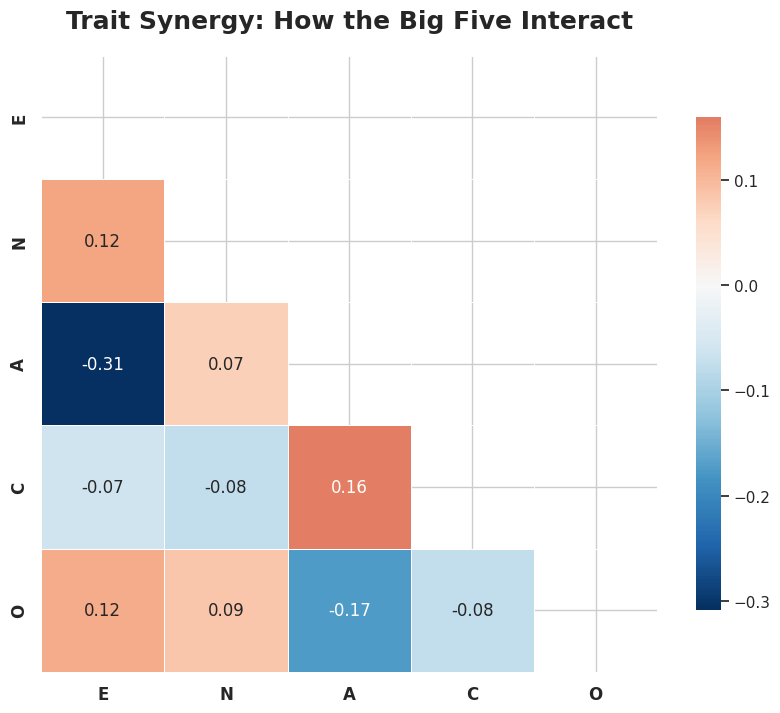

In [23]:
# 4. Trait Correlation Heatmap
plt.figure(figsize=(10, 8))

# Calculate how the 5 traits relate to each other
# Using the scores from Section 3
corr = df_big5[['E', 'N', 'A', 'C', 'O']].corr()

# Create a "Mask" for the upper triangle
# This makes it much cleaner by only showing the bottom half of the square
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap with a beautiful Red-to-Blue color scheme
sns.heatmap(
    corr,
    mask=mask,
    annot=True,          # Show the actual correlation numbers
    fmt=".2f",           # Round to 2 decimal places
    cmap='RdBu_r',       # Red for negative, Blue for positive
    center=0,            # 0 is the neutral white point
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title('Trait Synergy: How the Big Five Interact', fontsize=18, fontweight='bold', pad=20)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

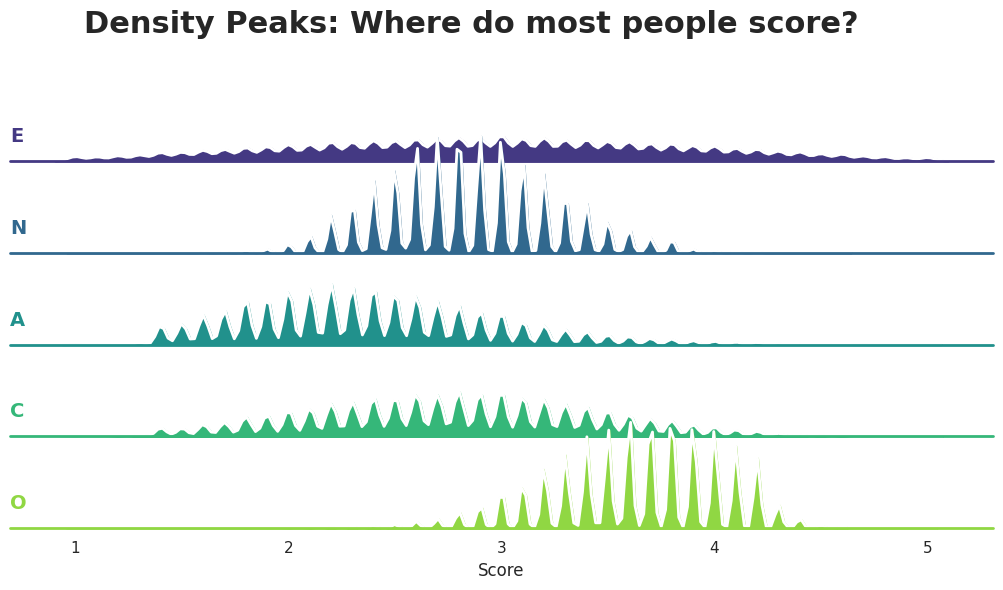

In [24]:
# 5. Personality "Mountain Range" (Ridge Plot)
# This shows the distribution of scores for each trait in a beautiful overlapping style.

# 1) Prepare the data for plotting: melt the 5 traits into a "long" format
df_melted = df_big5[['E', 'N', 'A', 'C', 'O']].melt(var_name='Trait', value_name='Score')

# 2) Set the aesthetic style
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# 3) Initialize the FacetGrid object
# Aspect=9 and height=1.2 creates the "narrow" overlapping rows
g = sns.FacetGrid(df_melted, row="Trait", hue="Trait", aspect=9, height=1.2, palette="viridis")

# 4) Draw the densities (the "mountains")
g.map(sns.kdeplot, "Score", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=.5)

# 5) Add a bottom line for each trait
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# 6) Define a function to label each row manually for a cleaner look
def label_rows(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes, fontsize=14)

g.map(label_rows, "Score")

# 7) Set the subplots to overlap slightly (this creates the ridge effect)
g.figure.subplots_adjust(hspace=-.25)

# 8) Remove axes details that aren't needed
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.suptitle('Density Peaks: Where do most people score?', fontsize=22, fontweight='bold', y=0.98)
plt.show()

# Reset theme for subsequent plots so they don't inherit the transparent background
sns.set_theme(style="whitegrid")

In [15]:
print("Shape of df_big5 (rows, columns):", df_big5.shape)
print("\nFirst 5 rows:")
display(df_big5.head())

print("\nSummary statistics:")
display(df_big5.describe())


Shape of df_big5 (rows, columns): (489489, 5)

First 5 rows:


E    N    A    C    O
0  4.6  3.2  2.1  3.0  4.1
1  2.0  2.7  2.0  2.3  3.7
2  2.5  2.8  2.0  2.4  3.9
3  2.6  3.1  2.2  3.7  3.7
4  2.9  3.5  1.8  1.6  4.4


Summary statistics:


E              N              A              C  \
count  489489.000000  489489.000000  489489.000000  489489.000000   
mean        2.953741       2.854690       2.405172       2.775286   
std         0.900459       0.395956       0.585558       0.652358   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.300000       2.600000       2.000000       2.300000   
50%         3.000000       2.800000       2.300000       2.800000   
75%         3.600000       3.100000       2.800000       3.200000   
max         5.000000       4.600000       5.000000       5.000000   

                   O  
count  489489.000000  
mean        3.630745  
std         0.402089  
min         1.000000  
25%         3.400000  
50%         3.700000  
75%         3.900000  
max         5.000000

In [16]:
# SECTION 5 – PCA: Dimensionality Reduction from 5D to 2D

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Standardize the 5 trait scores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_big5[["E", "N", "A", "C", "O"]])

# 2) PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3) Add PCA coordinates to df_big5
df_big5["PCA1"] = X_pca[:, 0]
df_big5["PCA2"] = X_pca[:, 1]

print("Explained variance by each PCA component:")
print(pca.explained_variance_ratio_)

print("\nFirst 5 rows with PCA:")
display(df_big5.head())


Explained variance by each PCA component:
[0.29871529 0.21175651]

First 5 rows with PCA:


E    N    A    C    O      PCA1      PCA2
0  4.6  3.2  2.1  3.0  4.1 -1.858889  0.636085
1  2.0  2.7  2.0  2.3  3.7 -0.078258 -0.511370
2  2.5  2.8  2.0  2.4  3.9 -0.590780 -0.247177
3  2.6  3.1  2.2  3.7  3.7  0.335532  0.243481
4  2.9  3.5  1.8  1.6  4.4 -2.322630  1.487391

In [17]:
# SECTION 6 – KMeans Clustering with a fixed number of clusters

from sklearn.cluster import KMeans

X_full = df_big5[["E", "N", "A", "C", "O"]].values

best_k = 7

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_big5["Cluster"] = kmeans_final.fit_predict(X_full)

print("Number of clusters:", best_k)
print("\nCluster sizes:")
print(df_big5["Cluster"].value_counts())


Number of clusters: 7

Cluster sizes:
Cluster
3    89154
4    75975
6    73643
0    72991
5    66022
2    62512
1    49192
Name: count, dtype: int64


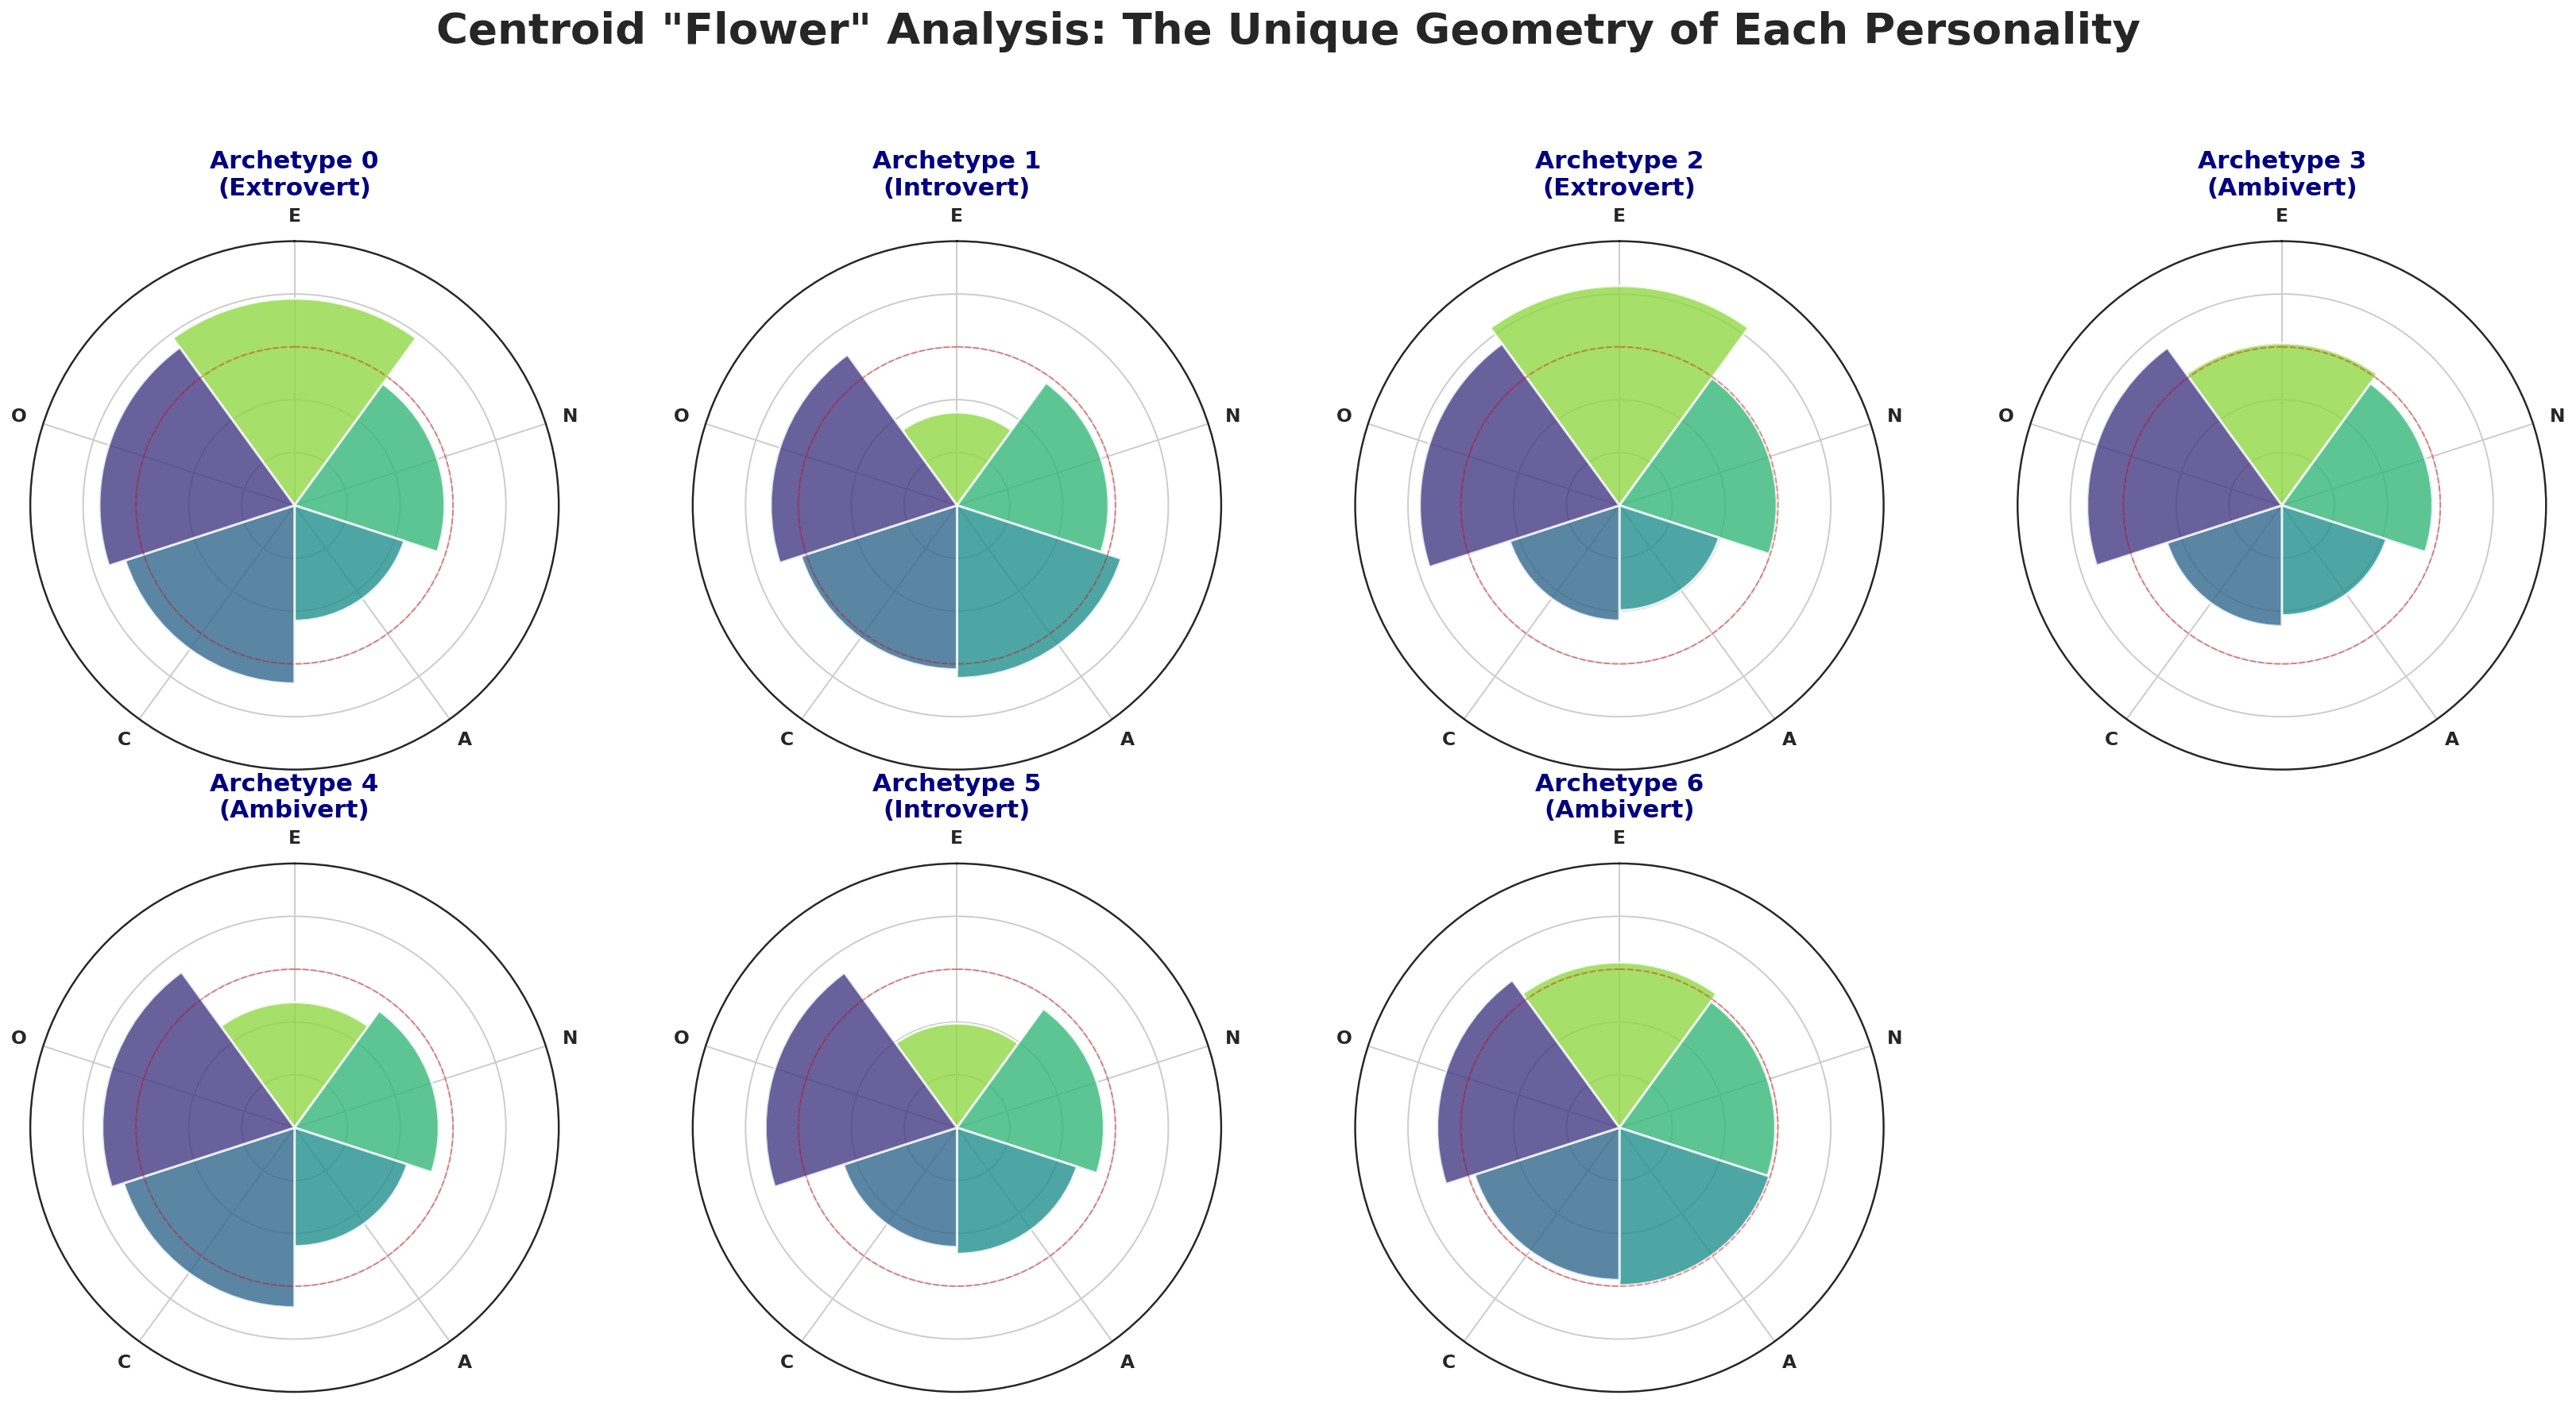

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Trait Data from the Centroids
# Note: We use kmeans_final.cluster_centers_ directly from Section 6
traits = ['E', 'N', 'A', 'C', 'O']
centroids = kmeans_final.cluster_centers_
n_traits = len(traits)

# 2. Setup the Plotting Parameters
plt.rcParams['figure.dpi'] = 140
sns.set_theme(style="white")

# Create a grid for the 7 clusters (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(24, 12), subplot_kw={'projection': 'polar'})
axes = axes.flatten()

# Sophisticated color palette for the 5 personality "petals"
colors = sns.color_palette("viridis_r", n_traits)
angles = np.linspace(0, 2 * np.pi, n_traits, endpoint=False)
width = (2 * np.pi) / n_traits

# 3. Create a "Flower" for each Cluster Centroid
for i in range(best_k):
    ax = axes[i]
    values = centroids[i]

    # Plot the "Petals" (Bars)
    # The height of the petal is the score, and the width is the segment of the circle
    bars = ax.bar(angles, values, width=width, bottom=0,
                  color=colors, alpha=0.8, edgecolor='white', linewidth=1.5)

    # Add a dashed baseline circle showing the global trait average (approx 3.0)
    # This helps see if a cluster is "Expanding" (high scores) or "Shrinking" (low scores)
    ax.plot(np.linspace(0, 2*np.pi, 100), [3.0]*100,
            color='red', linestyle='--', linewidth=1, alpha=0.4)

    # Styling for a clean, modern look
    ax.set_theta_offset(np.pi / 2) # Start E trait at the top
    ax.set_theta_direction(-1)     # Go clockwise
    ax.set_xticks(angles)
    ax.set_xticklabels(traits, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 5)              # Scores are 1-5
    ax.set_yticklabels([])         # Remove radial numbers for a clean "profile" feel

    # Title logic: use labels if you have run Section 8, otherwise use Cluster ID
    try:
        title = f"Archetype {i}\n({cluster_labels[i].split(',')[0]})"
    except (NameError, KeyError):
        title = f"Personality Archetype {i}"

    ax.set_title(title, size=16, color='navy', fontweight='bold', pad=30)

# Remove the empty 8th slot in the 2x4 grid
if len(axes) > best_k:
    fig.delaxes(axes[-1])

plt.suptitle('Centroid "Flower" Analysis: The Unique Geometry of Each Personality',
             fontsize=28, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [18]:
# SECTION 7 – Cluster Centers (average Big Five profile per cluster)

cluster_centers = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=["E", "N", "A", "C", "O"]
)
cluster_centers.index.name = "Cluster"

print("Cluster centers (mean trait scores):")
display(cluster_centers)


Cluster centers (mean trait scores):


E         N         A         C         O
Cluster                                                  
0        3.911747  2.841624  2.183136  3.369635  3.693204
1        1.758156  2.868183  3.266586  3.103610  3.524724
2        4.151304  2.978308  1.984515  2.181307  3.778420
3        3.068962  2.852067  2.080683  2.285373  3.684271
4        2.373101  2.729851  2.243497  3.401083  3.638158
5        1.971637  2.782590  2.387137  2.258216  3.622940
6        3.127683  2.950415  2.982773  2.882417  3.448798

In [19]:
# SECTION 8 – Rank-based personality labels (forces variety)

def assign_trait_words(values, low_word, mid_word, high_word):
    """
    values: pandas Series indexed by cluster_id, e.g. cluster_centers['E']
    returns: dict {cluster_id: word}
    """
    # sort clusters from low to high on this trait
    sorted_ids = values.sort_values().index.tolist()
    k = len(sorted_ids)

    # split into low / mid / high groups
    n_low = max(1, k // 3)
    n_high = max(1, k // 3)
    n_mid = k - n_low - n_high

    trait_label = {}

    # low group
    for cid in sorted_ids[:n_low]:
        trait_label[cid] = low_word

    # mid group
    for cid in sorted_ids[n_low:n_low + n_mid]:
        trait_label[cid] = mid_word

    # high group
    for cid in sorted_ids[n_low + n_mid:]:
        trait_label[cid] = high_word

    return trait_label


# 1) Create label dictionaries per trait using RANKS, not absolute thresholds
E_words = assign_trait_words(cluster_centers["E"],
                             low_word="Introvert",
                             mid_word="Ambivert",
                             high_word="Extrovert")

N_words = assign_trait_words(cluster_centers["N"],
                             low_word="Calm",
                             mid_word="Balanced",
                             high_word="Sensitive")

O_words = assign_trait_words(cluster_centers["O"],
                             low_word="Traditional",
                             mid_word="Open-minded",
                             high_word="Creative")

# (you could also do A_words, C_words similarly if needed)

# 2) Build final combined label per cluster
cluster_labels = {}

for cid in cluster_centers.index:
    e_label = E_words[cid]
    n_label = N_words[cid]
    o_label = O_words[cid]

    combined_label = f"{e_label}, {n_label}, {o_label}"
    cluster_labels[cid] = combined_label

print("Cluster → Personality label mapping (rank-based):")
for cid, label in cluster_labels.items():
    print(f"Cluster {cid}: {label}")

# 3) Attach to rows
df_big5["Personality_Label"] = df_big5["Cluster"].map(cluster_labels)

print("\nSample rows with labels:")
display(df_big5[["E", "N", "A", "C", "O", "Cluster", "Personality_Label"]].head())


Cluster → Personality label mapping (rank-based):
Cluster 0: Extrovert, Balanced, Creative
Cluster 1: Introvert, Balanced, Traditional
Cluster 2: Extrovert, Sensitive, Creative
Cluster 3: Ambivert, Balanced, Open-minded
Cluster 4: Ambivert, Calm, Open-minded
Cluster 5: Introvert, Calm, Open-minded
Cluster 6: Ambivert, Sensitive, Traditional

Sample rows with labels:


E    N    A    C    O  Cluster                Personality_Label
0  4.6  3.2  2.1  3.0  4.1        0    Extrovert, Balanced, Creative
1  2.0  2.7  2.0  2.3  3.7        5     Introvert, Calm, Open-minded
2  2.5  2.8  2.0  2.4  3.9        3  Ambivert, Balanced, Open-minded
3  2.6  3.1  2.2  3.7  3.7        4      Ambivert, Calm, Open-minded
4  2.9  3.5  1.8  1.6  4.4        3  Ambivert, Balanced, Open-minded

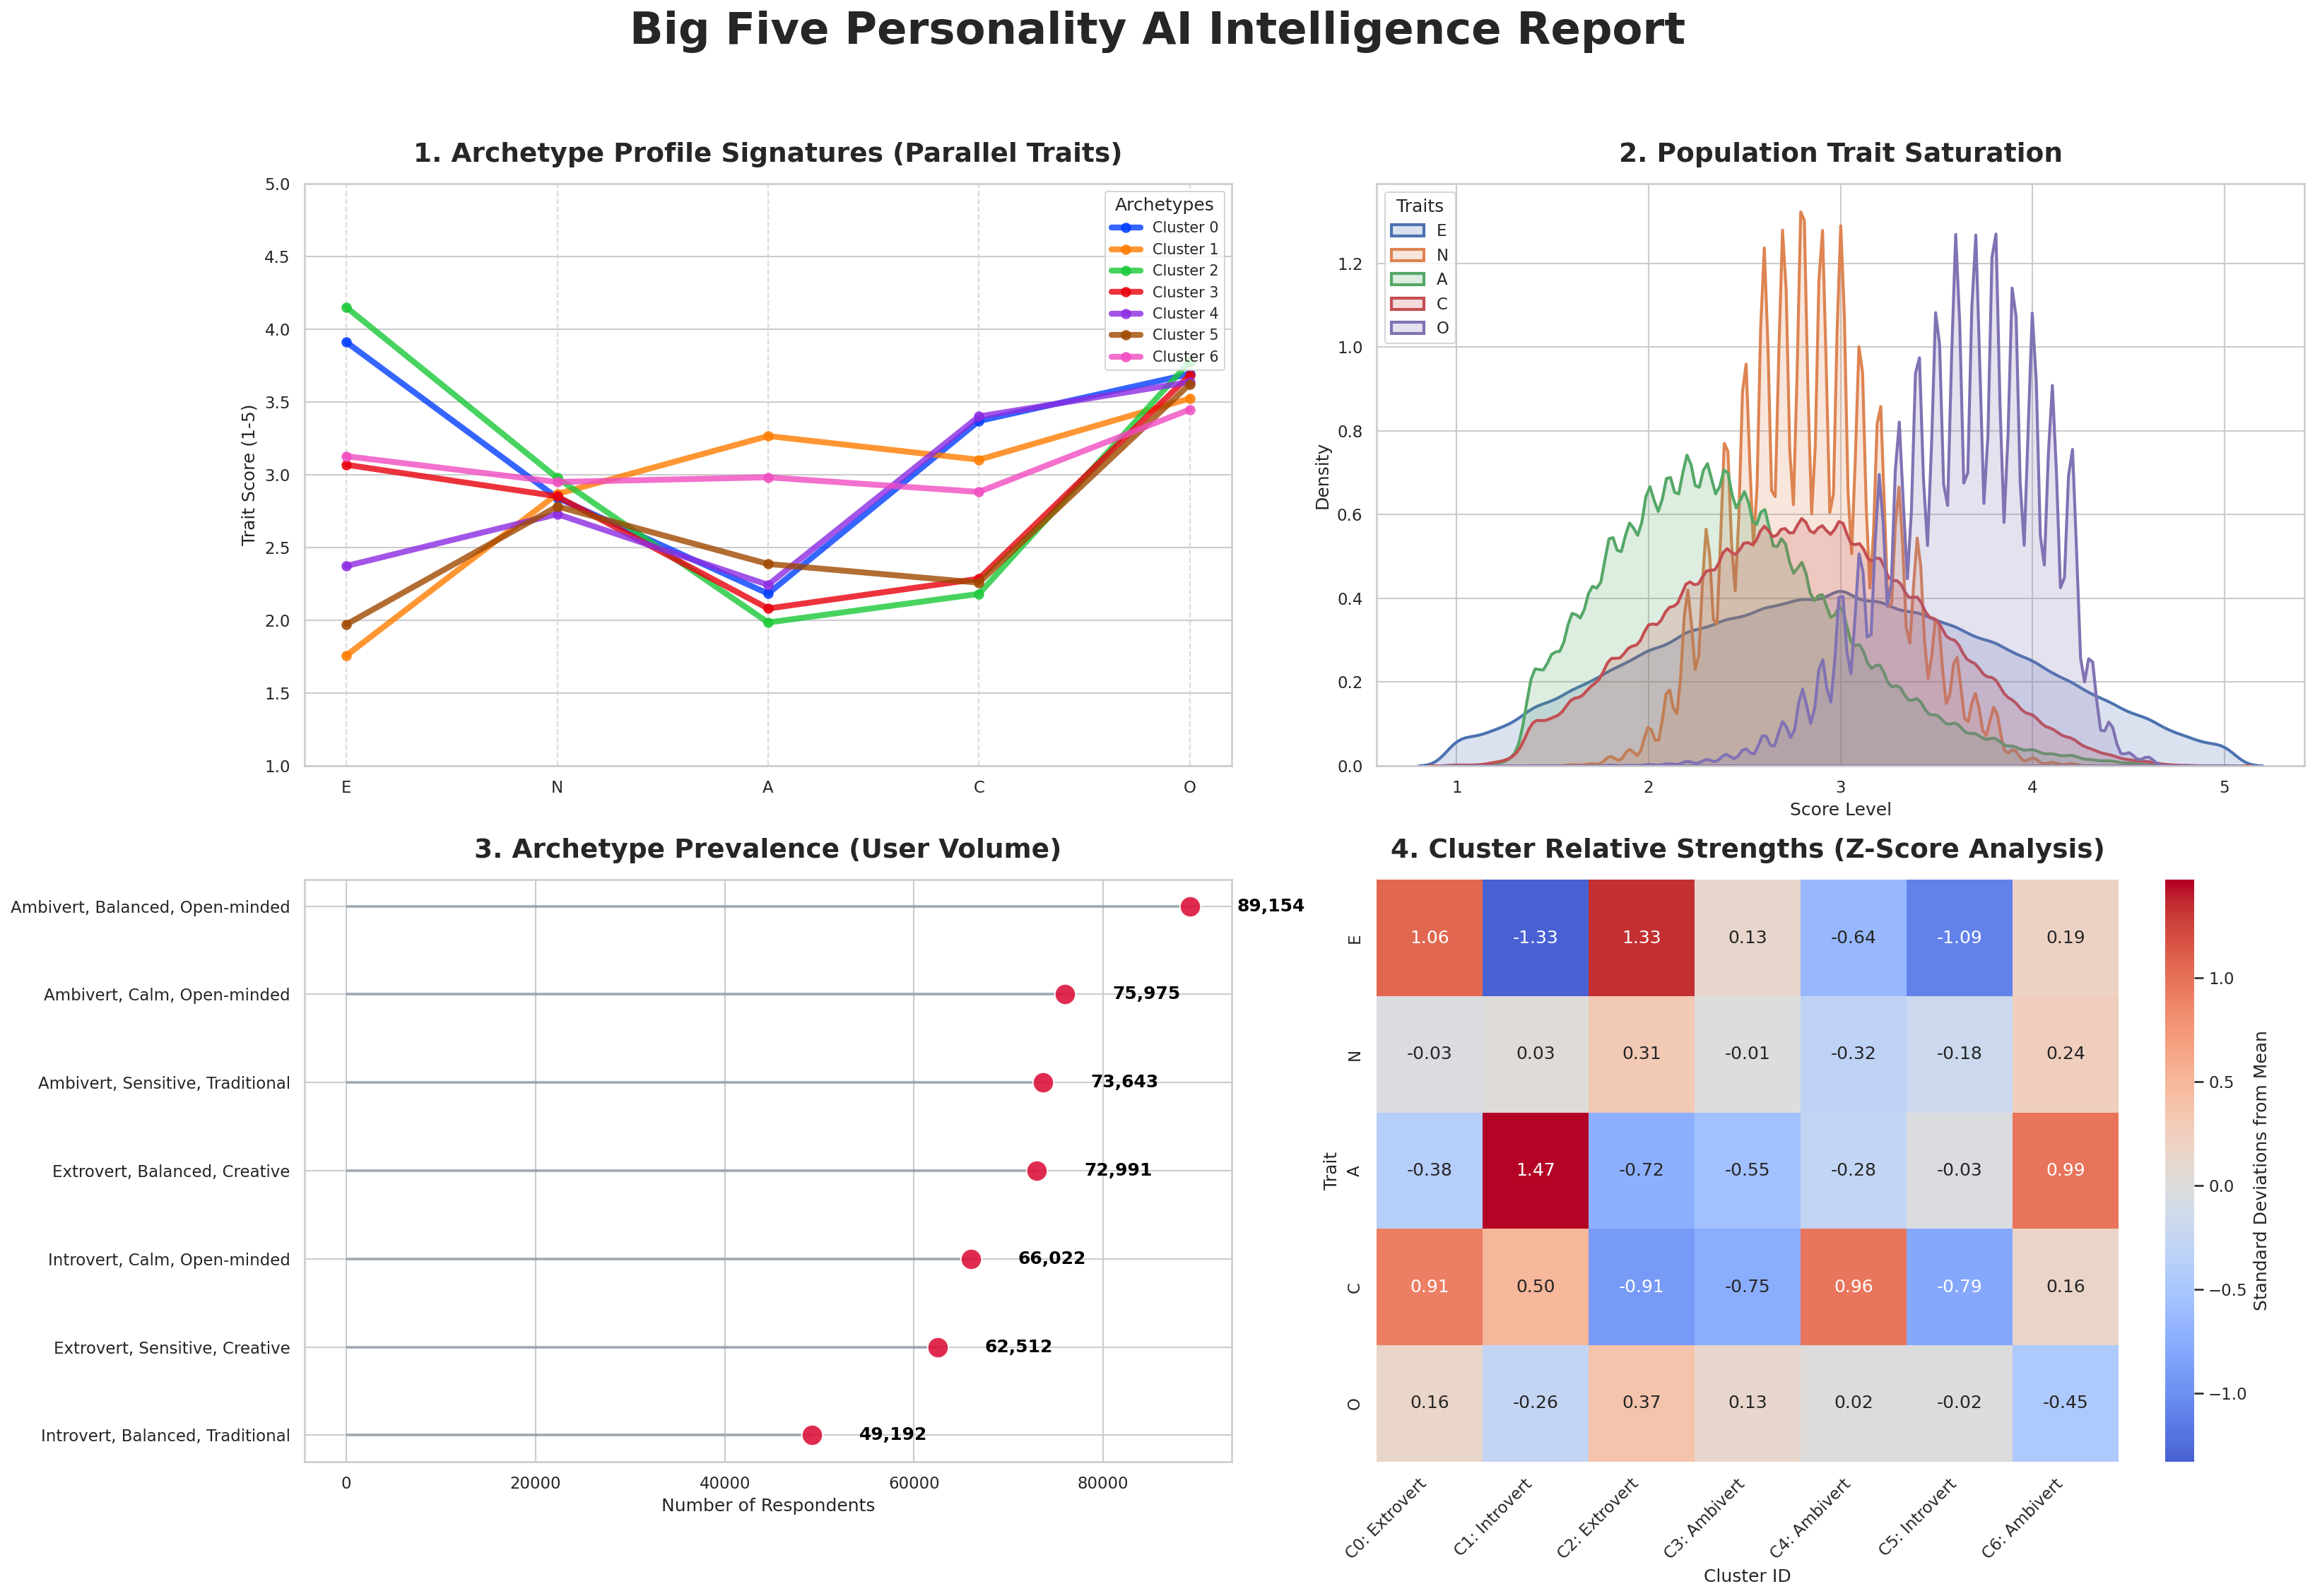

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Advanced Data Prep: Calculate Z-Scores & Population Metrics
traits = ["E", "N", "A", "C", "O"]
global_mean = df_big5[traits].mean()
global_std = df_big5[traits].std()
# Z-scores show how much a cluster deviates from the 'average' human
cluster_z_scores = (cluster_centers - global_mean) / global_std

# Population counts for the Lollipop chart
pop_counts = df_big5['Personality_Label'].value_counts().sort_values()

# Set high-definition visual parameters
plt.rcParams['figure.dpi'] = 150
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
fig.suptitle('Big Five Personality AI Intelligence Report', fontsize=30, fontweight='bold', y=0.97)

# ------------------------------------------------------------------
# CHART 1: Parallel Coordinates (The Archetype "DNA" Lines)
# ------------------------------------------------------------------
# This shows exactly how each cluster moves across the 5 traits.
# Each line represents the "signature" of a personality type.
palette = sns.color_palette("bright", 7)
for i, (idx, row) in enumerate(cluster_centers.iterrows()):
    axes[0, 0].plot(traits, row, marker='o', linewidth=4, label=f"Cluster {idx}", color=palette[i], alpha=0.8)

axes[0, 0].set_title('1. Archetype Profile Signatures (Parallel Traits)', fontsize=18, fontweight='bold', pad=15)
axes[0, 0].set_ylim(1, 5)
axes[0, 0].set_ylabel('Trait Score (1-5)', fontsize=12)
axes[0, 0].legend(title="Archetypes", loc='upper right', fontsize='small', frameon=True)
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)

# ------------------------------------------------------------------
# CHART 2: Global Trait Saturation (KDE Overlap)
# ------------------------------------------------------------------
# Shows the probability density—where the "weight" of the 700k people lies.
for trait in traits:
    sns.kdeplot(df_big5[trait], ax=axes[0, 1], label=trait, fill=True, alpha=0.2, linewidth=2)
axes[0, 1].set_title('2. Population Trait Saturation', fontsize=18, fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Score Level')
axes[0, 1].legend(title="Traits", loc='upper left')

# ------------------------------------------------------------------
# CHART 3: Lollipop Population Map (Sleek Frequency View)
# ------------------------------------------------------------------
# A modern, clean alternative to bar charts. Shows the "popularity" of each archetype.
axes[1, 0].hlines(y=pop_counts.index, xmin=0, xmax=pop_counts.values, color='slategray', alpha=0.5, linewidth=2)
axes[1, 0].scatter(pop_counts.values, pop_counts.index, s=200, color='crimson', alpha=0.9, edgecolors='white', zorder=3)

axes[1, 0].set_title('3. Archetype Prevalence (User Volume)', fontsize=18, fontweight='bold', pad=15)
axes[1, 0].set_xlabel('Number of Respondents')
# Add data labels to the lollipops
for i, v in enumerate(pop_counts.values):
    axes[1, 0].text(v + 5000, i, f"{v:,}", color='black', va='center', fontweight='bold')

# ------------------------------------------------------------------
# CHART 4: Z-Score Deviation Matrix (The "Insight" Map)
# ------------------------------------------------------------------
# The most professional chart: Red = Above Average, Blue = Below Average.
sns.heatmap(cluster_z_scores.T, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            ax=axes[1, 1], cbar_kws={'label': 'Standard Deviations from Mean'})
axes[1, 1].set_title('4. Cluster Relative Strengths (Z-Score Analysis)', fontsize=18, fontweight='bold', pad=15)
axes[1, 1].set_ylabel('Trait')
axes[1, 1].set_xlabel('Cluster ID')

# Label X-axis with the primary characteristic of each cluster
short_labels = [f"C{i}: {label.split(',')[0]}" for i, label in cluster_labels.items()]
axes[1, 1].set_xticklabels(short_labels, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

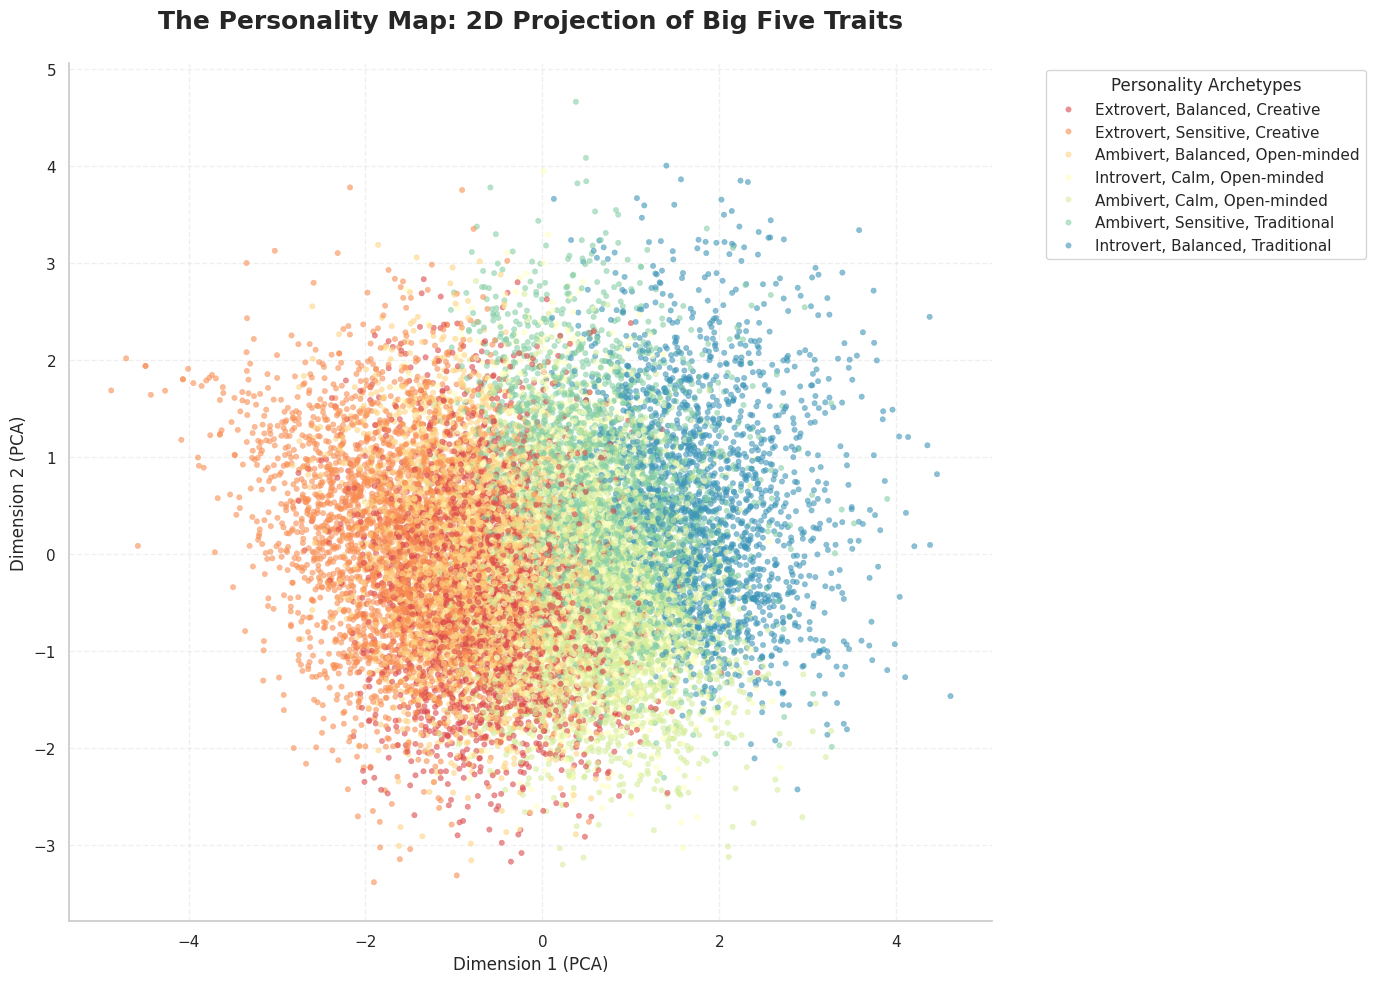

In [21]:
# 2. PCA Personality "Map" (The Cloud)
plt.figure(figsize=(14, 10))

# We take a sample of 20,000 rows to ensure the plot is beautiful and responsive
# Your original df_big5 has >700k rows, so a sample is perfect for visualization.
df_sample = df_big5.sample(n=min(20000, len(df_big5)), random_state=42)

# Create the scatter plot using the PCA components from Section 5
scatter = sns.scatterplot(
    data=df_sample,
    x='PCA1',
    y='PCA2',
    hue='Personality_Label',
    palette='Spectral',
    alpha=0.6,
    edgecolor=None,
    s=15
)

# Professional styling
plt.title('The Personality Map: 2D Projection of Big Five Traits', fontsize=18, fontweight='bold', pad=25)
plt.xlabel('Dimension 1 (PCA)', fontsize=12)
plt.ylabel('Dimension 2 (PCA)', fontsize=12)

# Position the legend outside the plot area
plt.legend(title='Personality Archetypes', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

plt.grid(True, linestyle='--', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()

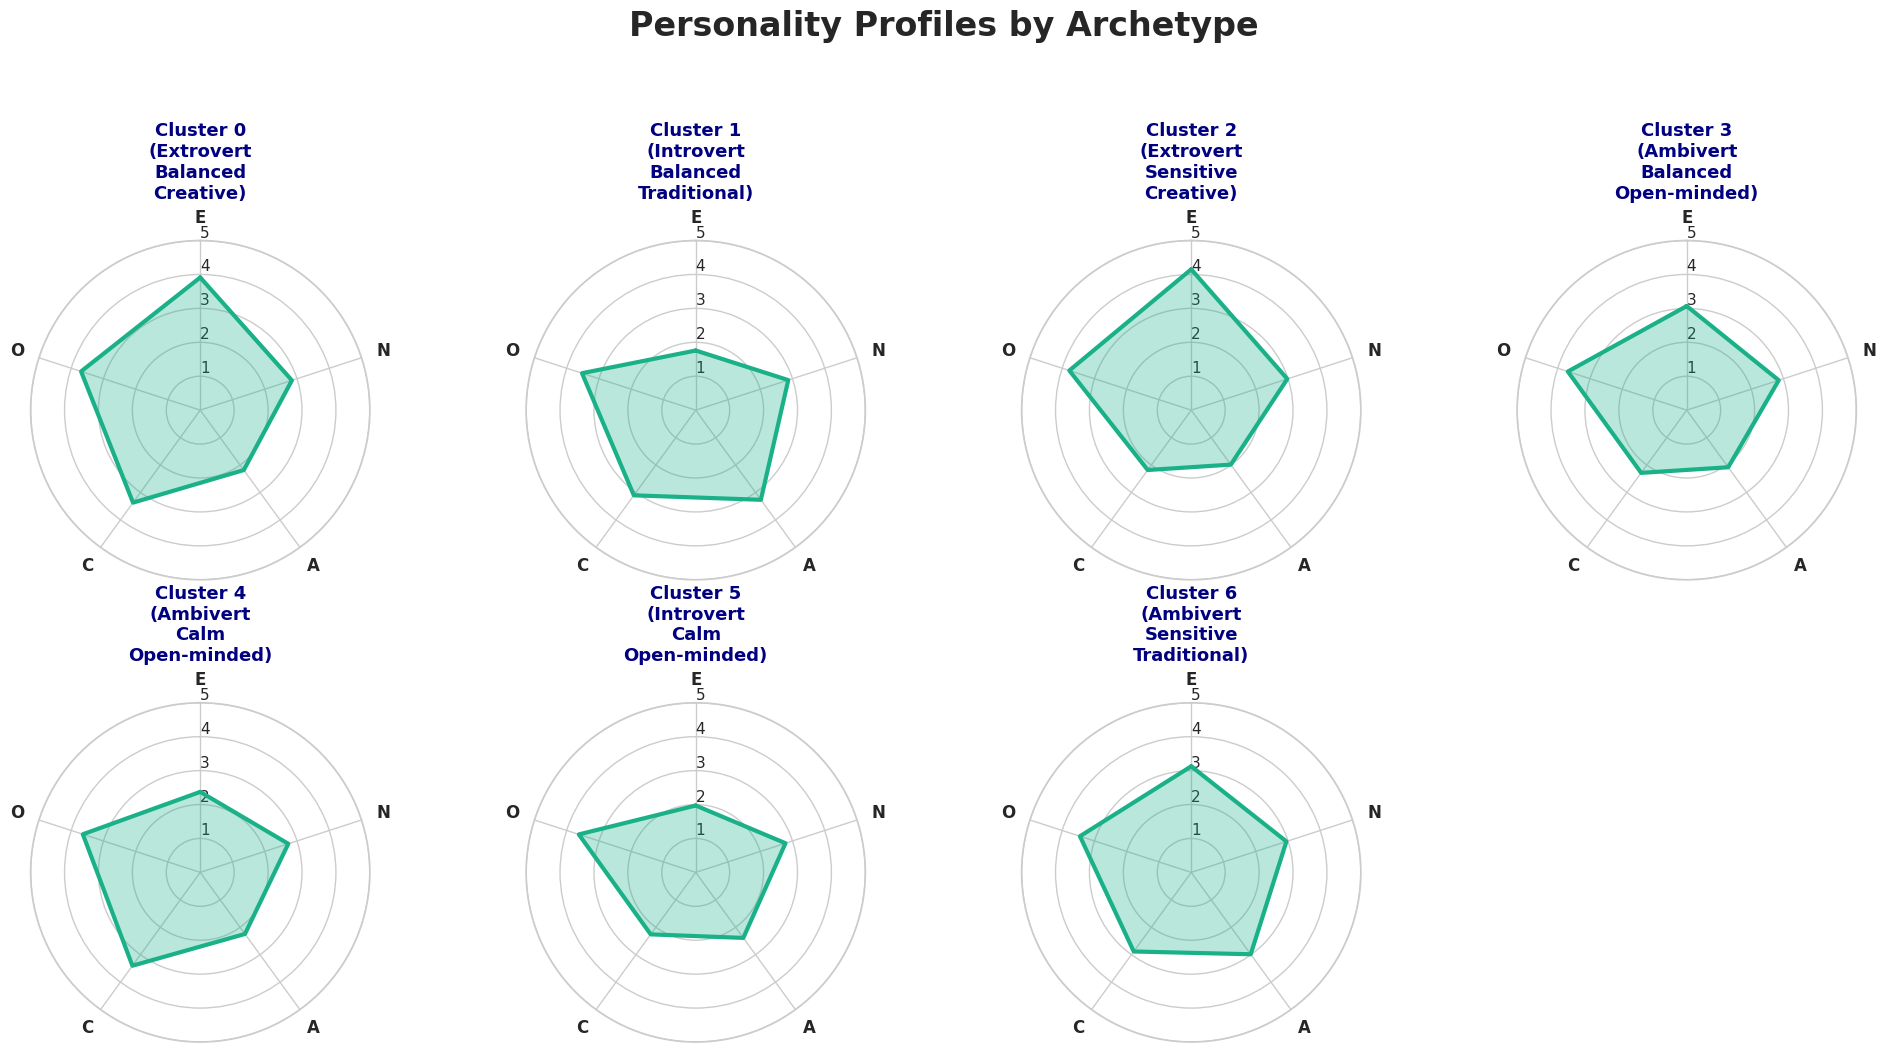

In [22]:
import numpy as np

# 3. Radar Chart Gallery: The "Shape" of each Personality
categories = ['E', 'N', 'A', 'C', 'O']
num_vars = len(categories)

# Compute angles for the radar plot
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1] # Close the circle to complete the "spider web"

# Create a grid for the 7 clusters (2 rows, 4 columns - 8th slot will be empty)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), subplot_kw={'projection': 'polar'})
axes = axes.flatten()

# Iterate through each cluster center to plot its profile
for i, (cluster_id, row) in enumerate(cluster_centers.iterrows()):
    # Prepare data for this specific cluster
    values = row.tolist()
    values += values[:1] # Close the circle

    ax = axes[i]

    # Draw the plot outline and fill it
    ax.plot(angles, values, color='#1ab188', linewidth=3, linestyle='solid')
    ax.fill(angles, values, color='#1ab188', alpha=0.3)

    # Styling the circular grid
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Set the labels for each "arm" of the spider chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')

    # Personality scores range from 1 to 5
    ax.set_ylim(0, 5)
    ax.set_rlabel_position(0)
    plt.yticks([1, 2, 3, 4], ["1", "2", "3", "4"], color="grey", size=8)

    # Add titles using the rank-based labels we created in Section 8
    label_text = cluster_labels[cluster_id].replace(", ", "\n")
    ax.set_title(f"Cluster {cluster_id}\n({label_text})", size=13, color='navy', fontweight='bold', pad=30)

# Remove the empty 8th subplot (since you have 7 clusters)
if len(cluster_centers) < len(axes):
    fig.delaxes(axes[-1])

plt.suptitle('Personality Profiles by Archetype', fontsize=24, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [25]:
# EXTRA SECTION – Per-user trait descriptions (more variety)

def describe_trait_value(series, low_word, mid_word, high_word):
    """
    series: a pandas Series of one trait over all users (e.g. df_big5['E'])
    returns: Series of same length with words (low/mid/high)
    """
    low_t = series.quantile(0.33)
    high_t = series.quantile(0.67)

    def label(v):
        if v <= low_t:
            return low_word
        elif v >= high_t:
            return high_word
        else:
            return mid_word

    return series.apply(label)

# Per-user labels for each trait
df_big5["E_word"] = describe_trait_value(df_big5["E"],
                                         low_word="Introvert",
                                         mid_word="Ambivert",
                                         high_word="Extrovert")

df_big5["N_word"] = describe_trait_value(df_big5["N"],
                                         low_word="Calm",
                                         mid_word="Balanced",
                                         high_word="Sensitive")

df_big5["O_word"] = describe_trait_value(df_big5["O"],
                                         low_word="Traditional",
                                         mid_word="Open-minded",
                                         high_word="Creative")

df_big5["C_word"] = describe_trait_value(df_big5["C"],
                                         low_word="Relaxed",
                                         mid_word="Balanced",
                                         high_word="Organized")

# Optional: Agreeableness too
df_big5["A_word"] = describe_trait_value(df_big5["A"],
                                         low_word="Reserved",
                                         mid_word="Warm",
                                         high_word="Compassionate")

# Combined per-user trait combo text
df_big5["Trait_Combo"] = (
    df_big5["E_word"] + " · " +
    df_big5["N_word"] + " · " +
    df_big5["O_word"] + " · " +
    df_big5["C_word"] + " . " +
    df_big5["A_word"]
    )

print("Sample rows with rich trait combo:")
display(df_big5[["E", "N", "A", "C", "O",
                 "Cluster", "Personality_Label",
                 "E_word", "N_word", "O_word", "C_word",  "A_word",
                 "Trait_Combo"]].head())


Sample rows with rich trait combo:


E    N    A    C    O  Cluster                Personality_Label  \
0  4.6  3.2  2.1  3.0  4.1        0    Extrovert, Balanced, Creative   
1  2.0  2.7  2.0  2.3  3.7        5     Introvert, Calm, Open-minded   
2  2.5  2.8  2.0  2.4  3.9        3  Ambivert, Balanced, Open-minded   
3  2.6  3.1  2.2  3.7  3.7        4      Ambivert, Calm, Open-minded   
4  2.9  3.5  1.8  1.6  4.4        3  Ambivert, Balanced, Open-minded   

      E_word     N_word       O_word     C_word    A_word  \
0  Extrovert  Sensitive     Creative   Balanced  Reserved   
1  Introvert       Calm  Open-minded    Relaxed  Reserved   
2  Introvert   Balanced     Creative    Relaxed  Reserved   
3   Ambivert  Sensitive  Open-minded  Organized      Warm   
4   Ambivert  Sensitive     Creative    Relaxed  Reserved   

                                         Trait_Combo  
0  Extrovert · Sensitive · Creative · Balanced . ...  
1  Introvert · Calm · Open-minded · Relaxed . Res...  
2  Introvert · Balanced · Creative · Relaxed . Re...  
3  Ambivert · Sensitive · Open-minded · Organized...  
4  Ambivert · Sensitive · Creative · Relaxed . Re...

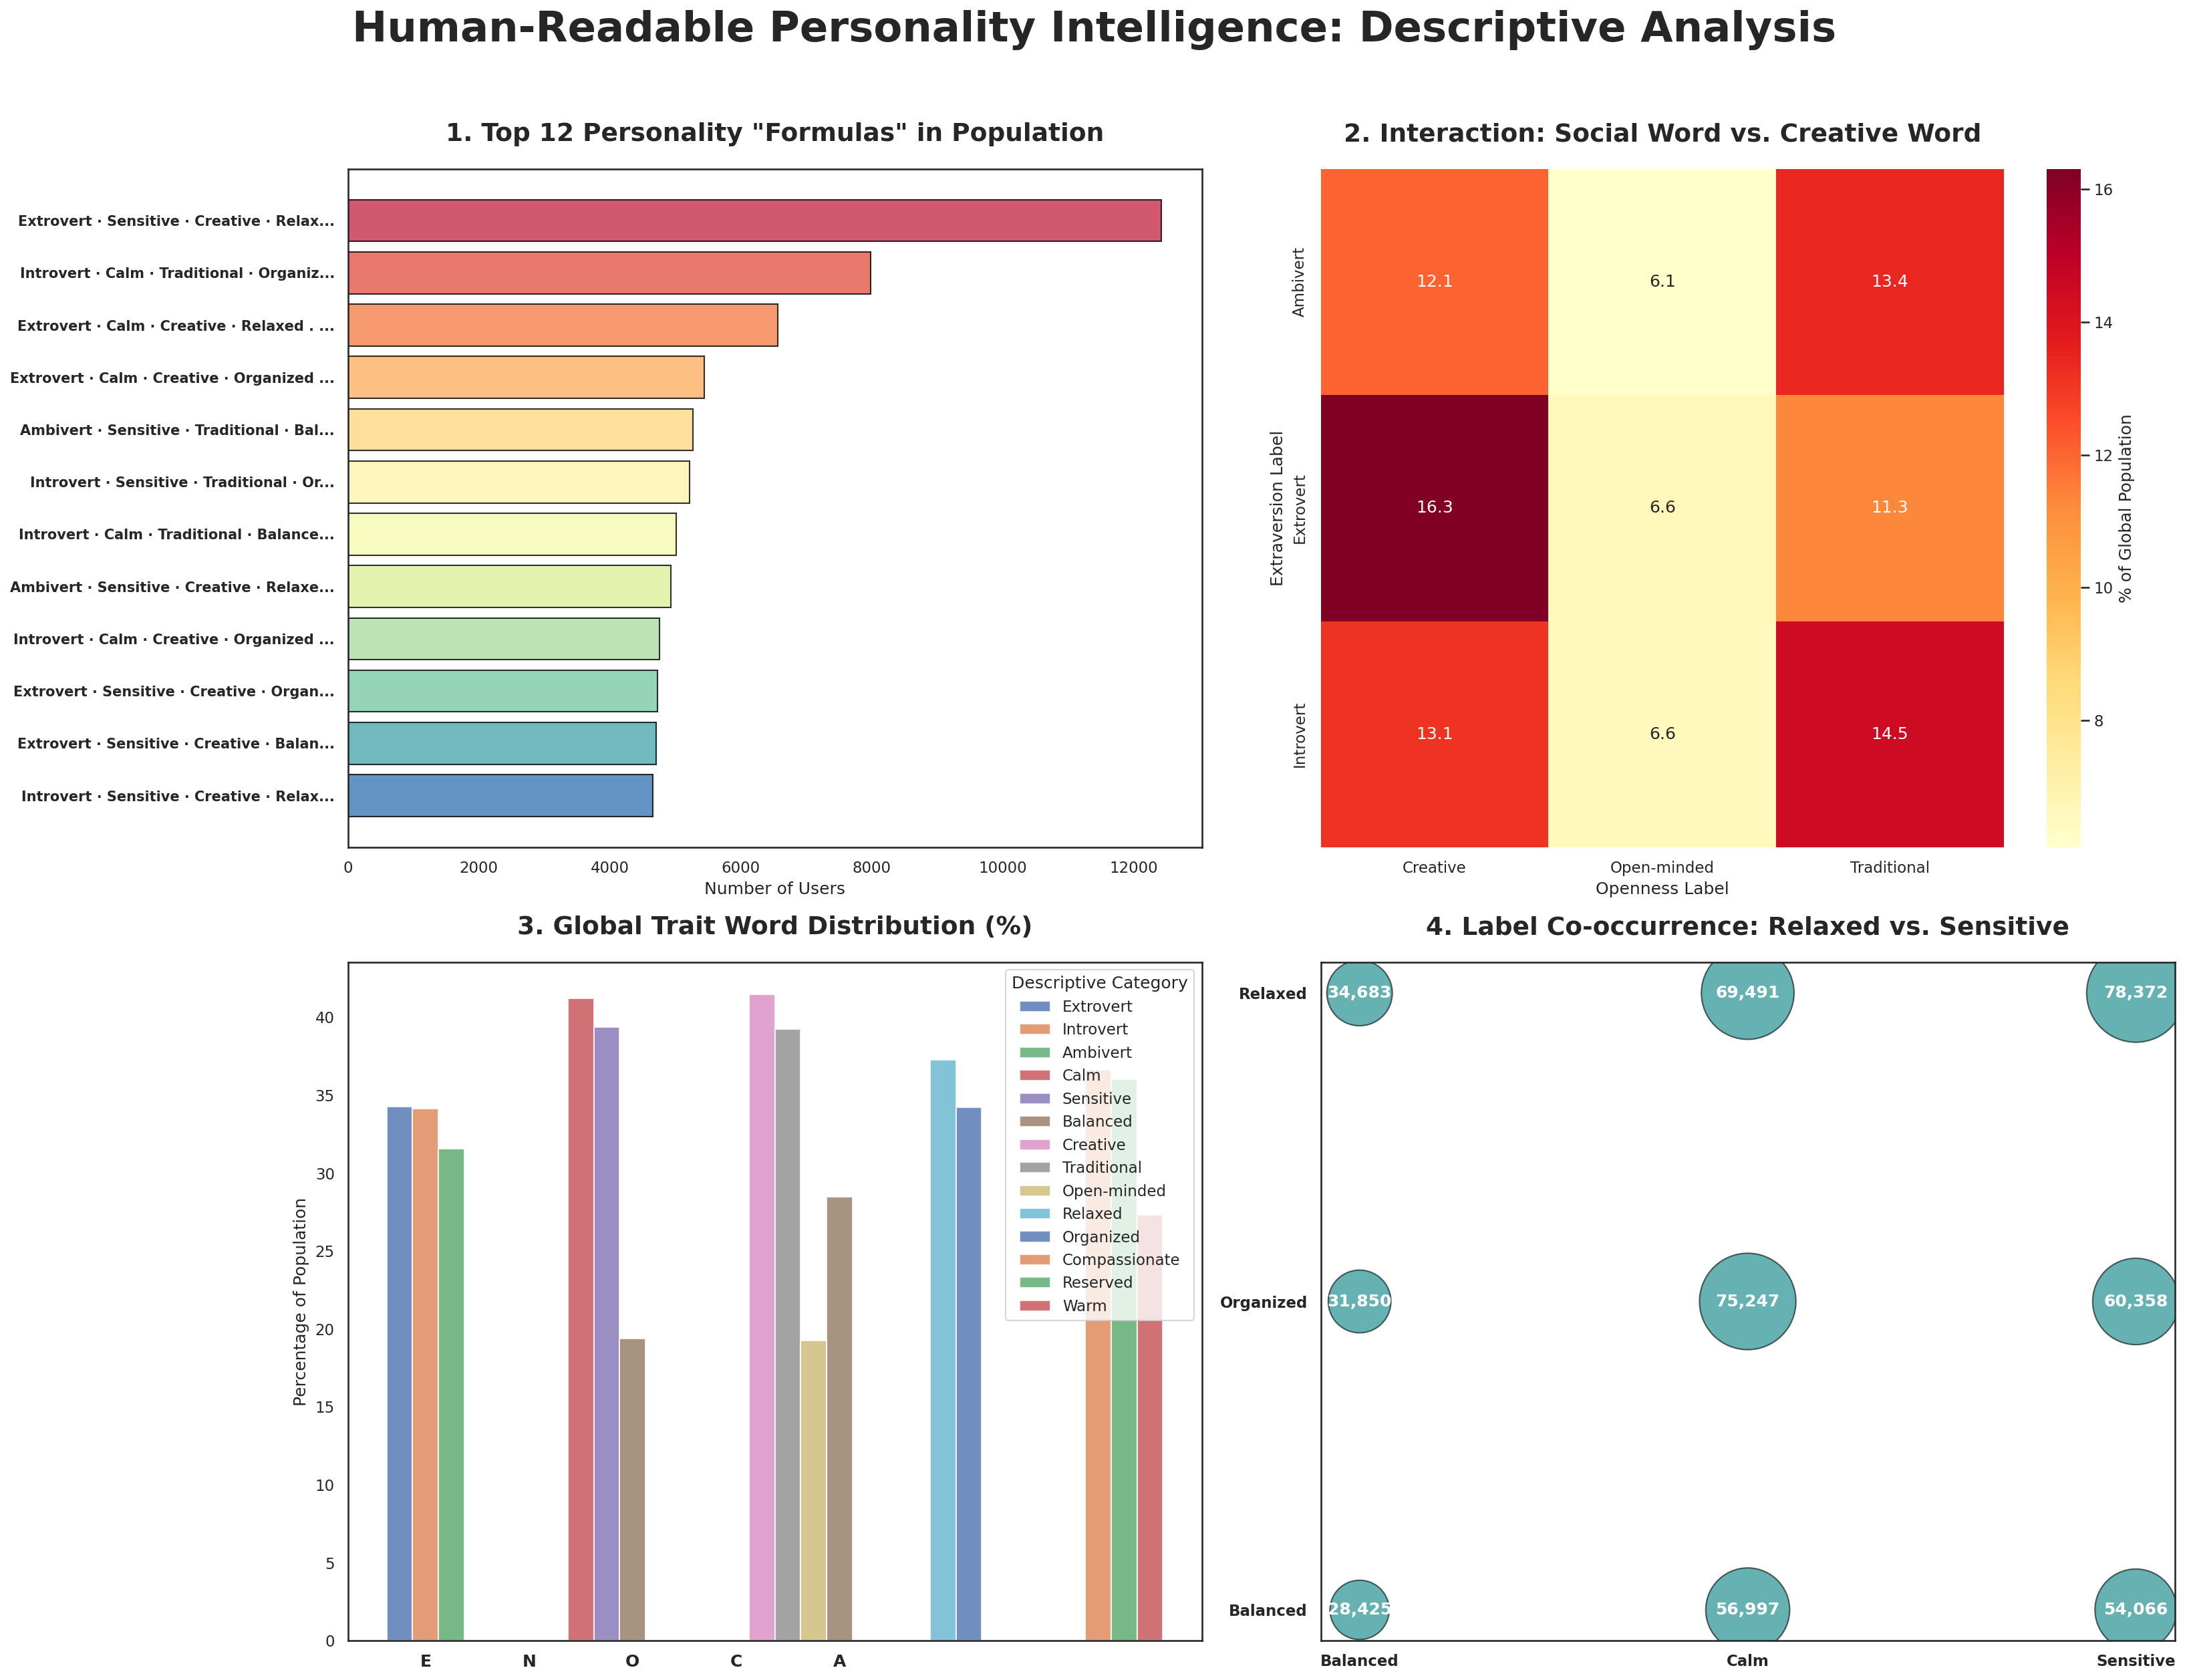

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Prepare Categorical Data for the Dashboard
# Get top 12 most frequent personality formulas
top_combos = df_big5['Trait_Combo'].value_counts().head(12)

# Create a cross-tabulation for Heatmap (Social vs. Creative)
ct_matrix = pd.crosstab(df_big5['E_word'], df_big5['O_word'], normalize='all') * 100

# Prepare data for Polar Word Frequency
# Counts of each label for each trait
word_cols = ['E_word', 'N_word', 'O_word', 'C_word', 'A_word']
plot_data = []
for col in word_cols:
    counts = df_big5[col].value_counts(normalize=True) * 100
    for label, val in counts.items():
        plot_data.append({'Trait': col.replace('_word',''), 'Label': label, 'Percentage': val})
df_polar = pd.DataFrame(plot_data)

# Set high-definition style
plt.rcParams['figure.dpi'] = 150
sns.set_theme(style="white")

fig, axes = plt.subplots(2, 2, figsize=(22, 18))
fig.suptitle('Human-Readable Personality Intelligence: Descriptive Analysis',
             fontsize=30, fontweight='bold', y=0.96)

# ------------------------------------------------------------------
# CHART 1: The Personality Mosaic (Top Formula Frequency)
# ------------------------------------------------------------------
# Replaces boring bars. Shows the "Hierarchy" of personality types.
colors = sns.color_palette("Spectral", len(top_combos))
y_pos = np.arange(len(top_combos))
axes[0, 0].barh(y_pos, top_combos.values, color=colors, edgecolor='black', alpha=0.8)
axes[0, 0].set_yticks(y_pos)
axes[0, 0].set_yticklabels([label[:40] + "..." if len(label) > 40 else label for label in top_combos.index],
                           fontsize=10, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].set_title('1. Top 12 Personality "Formulas" in Population', fontsize=18, fontweight='bold', pad=20)
axes[0, 0].set_xlabel('Number of Users')

# ------------------------------------------------------------------
# CHART 2: Social vs. Creative Synergy (Categorical Heatmap)
# ------------------------------------------------------------------
# Shows the intersection of two key traits in human-readable words
sns.heatmap(ct_matrix, annot=True, fmt=".1f", cmap="YlOrRd", ax=axes[0, 1],
            cbar_kws={'label': '% of Global Population'})
axes[0, 1].set_title('2. Interaction: Social Word vs. Creative Word', fontsize=18, fontweight='bold', pad=20)
axes[0, 1].set_ylabel('Extraversion Label')
axes[0, 1].set_xlabel('Openness Label')

# ------------------------------------------------------------------
# CHART 3: Label Dominance (Polar Bar Chart)
# ------------------------------------------------------------------
# Shows the distribution of Low/Mid/High labels across all 5 traits
traits_list = ['E', 'N', 'O', 'C', 'A']
labels_list = df_polar['Label'].unique()
x = np.arange(len(traits_list))
width = 0.25

for i, label in enumerate(labels_list):
    subset = df_polar[df_polar['Label'] == label].set_index('Trait').reindex(traits_list)
    axes[1, 0].bar(x + i*width, subset['Percentage'], width, label=label, alpha=0.8)

axes[1, 0].set_title('3. Global Trait Word Distribution (%)', fontsize=18, fontweight='bold', pad=20)
axes[1, 0].set_xticks(x + width)
axes[1, 0].set_xticklabels(traits_list, fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Percentage of Population')
axes[1, 0].legend(title="Descriptive Category")

# ------------------------------------------------------------------
# CHART 4: Trait Word Co-occurrence (Bubble Matrix)
# ------------------------------------------------------------------
# Visualizes how descriptive words cluster together
# We simulate this with a specific cross-tab of Conscientiousness vs Neuroticism
ct_cn = pd.crosstab(df_big5['C_word'], df_big5['N_word'])
x_coords, y_coords = np.meshgrid(np.arange(ct_cn.shape[1]), np.arange(ct_cn.shape[0]))
s = ct_cn.values.flatten() / ct_cn.values.max() * 5000 # Bubble size based on frequency

axes[1, 1].scatter(x_coords.flatten(), y_coords.flatten(), s=s, color='teal', alpha=0.6, edgecolors='black')
axes[1, 1].set_xticks(np.arange(ct_cn.shape[1]))
axes[1, 1].set_xticklabels(ct_cn.columns, fontweight='bold')
axes[1, 1].set_yticks(np.arange(ct_cn.shape[0]))
axes[1, 1].set_yticklabels(ct_cn.index, fontweight='bold')
axes[1, 1].set_title('4. Label Co-occurrence: Relaxed vs. Sensitive', fontsize=18, fontweight='bold', pad=20)

for i in range(ct_cn.shape[0]):
    for j in range(ct_cn.shape[1]):
        axes[1, 1].text(j, i, f"{ct_cn.iloc[i, j]:,}", ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

In [26]:
# SECTION 9 – Save trained ML objects for later use (backend / deployment)

import joblib

joblib.dump(scaler, "scaler_big5.pkl")
joblib.dump(pca, "pca_big5.pkl")
joblib.dump(kmeans_final, "kmeans_big5.pkl")
joblib.dump(cluster_labels, "cluster_labels_dict.pkl")

print("Saved: scaler_big5.pkl, pca_big5.pkl, kmeans_big5.pkl, cluster_labels_dict.pkl")


Saved: scaler_big5.pkl, pca_big5.pkl, kmeans_big5.pkl, cluster_labels_dict.pkl


In [27]:
# SECTION 10 – Prediction function (from traits to personality island info)

import numpy as np

def predict_personality_from_traits(E, N, A, C, O):
    """
    Input:  five trait scores (1–5 each).
    Output: dict with cluster, label, PCA coords and trait words.
    """

    # 1) Put into array
    x = np.array([[E, N, A, C, O]])

    # 2) Standardize with the trained scaler
    x_scaled = scaler.transform(x)

    # 3) PCA transform
    x_pca = pca.transform(x_scaled)
    pca1, pca2 = float(x_pca[0, 0]), float(x_pca[0, 1])

    # 4) Cluster prediction
    cluster = int(kmeans_final.predict(x)[0])

    # 5) Cluster-level label
    archetype_label = cluster_labels[cluster]

    # 6) Per-user trait words (same logic as before)

    def one_trait_word(value, series, low_word, mid_word, high_word):
        low_t = series.quantile(0.33)
        high_t = series.quantile(0.67)
        if value <= low_t:
            return low_word
        elif value >= high_t:
            return high_word
        else:
            return mid_word

    E_word = one_trait_word(E, df_big5["E"], "Introvert", "Ambivert", "Extrovert")
    N_word = one_trait_word(N, df_big5["N"], "Calm", "Balanced", "Sensitive")
    O_word = one_trait_word(O, df_big5["O"], "Traditional", "Open-minded", "Creative")
    C_word = one_trait_word(C, df_big5["C"], "Relaxed", "Balanced", "Organized")
    A_word = one_trait_word(A, df_big5["A"], "Reserved", "Warm", "Compassionate")

    trait_combo = f"{E_word} · {N_word} · {O_word} · {C_word} · {A_word}"

    return {
        "E": float(E), "N": float(N), "A": float(A), "C": float(C), "O": float(O),
        "cluster": cluster,
        "archetype_label": archetype_label,
        "E_word": E_word,
        "N_word": N_word,
        "O_word": O_word,
        "C_word": C_word,
        "A_word": A_word,
        "trait_combo": trait_combo,
        "PCA1": pca1,
        "PCA2": pca2,
    }

# Quick test:
test_result = predict_personality_from_traits(3.5, 2.0, 4.0, 3.0, 4.5)
test_result


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'E': 3.5,
 'N': 2.0,
 'A': 4.0,
 'C': 3.0,
 'O': 4.5,
 'cluster': 6,
 'archetype_label': 'Ambivert, Sensitive, Traditional',
 'E_word': 'Extrovert',
 'N_word': 'Calm',
 'O_word': 'Creative',
 'C_word': 'Balanced',
 'A_word': 'Compassionate',
 'trait_combo': 'Extrovert · Calm · Creative · Balanced · Compassionate',
 'PCA1': 0.8547327354897266,
 'PCA2': -0.4821187996137528}

/tmp/ipython-input-310137221.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dist_df, x='Distance', y='Cluster', palette="mako", ax=axes[1, 0])


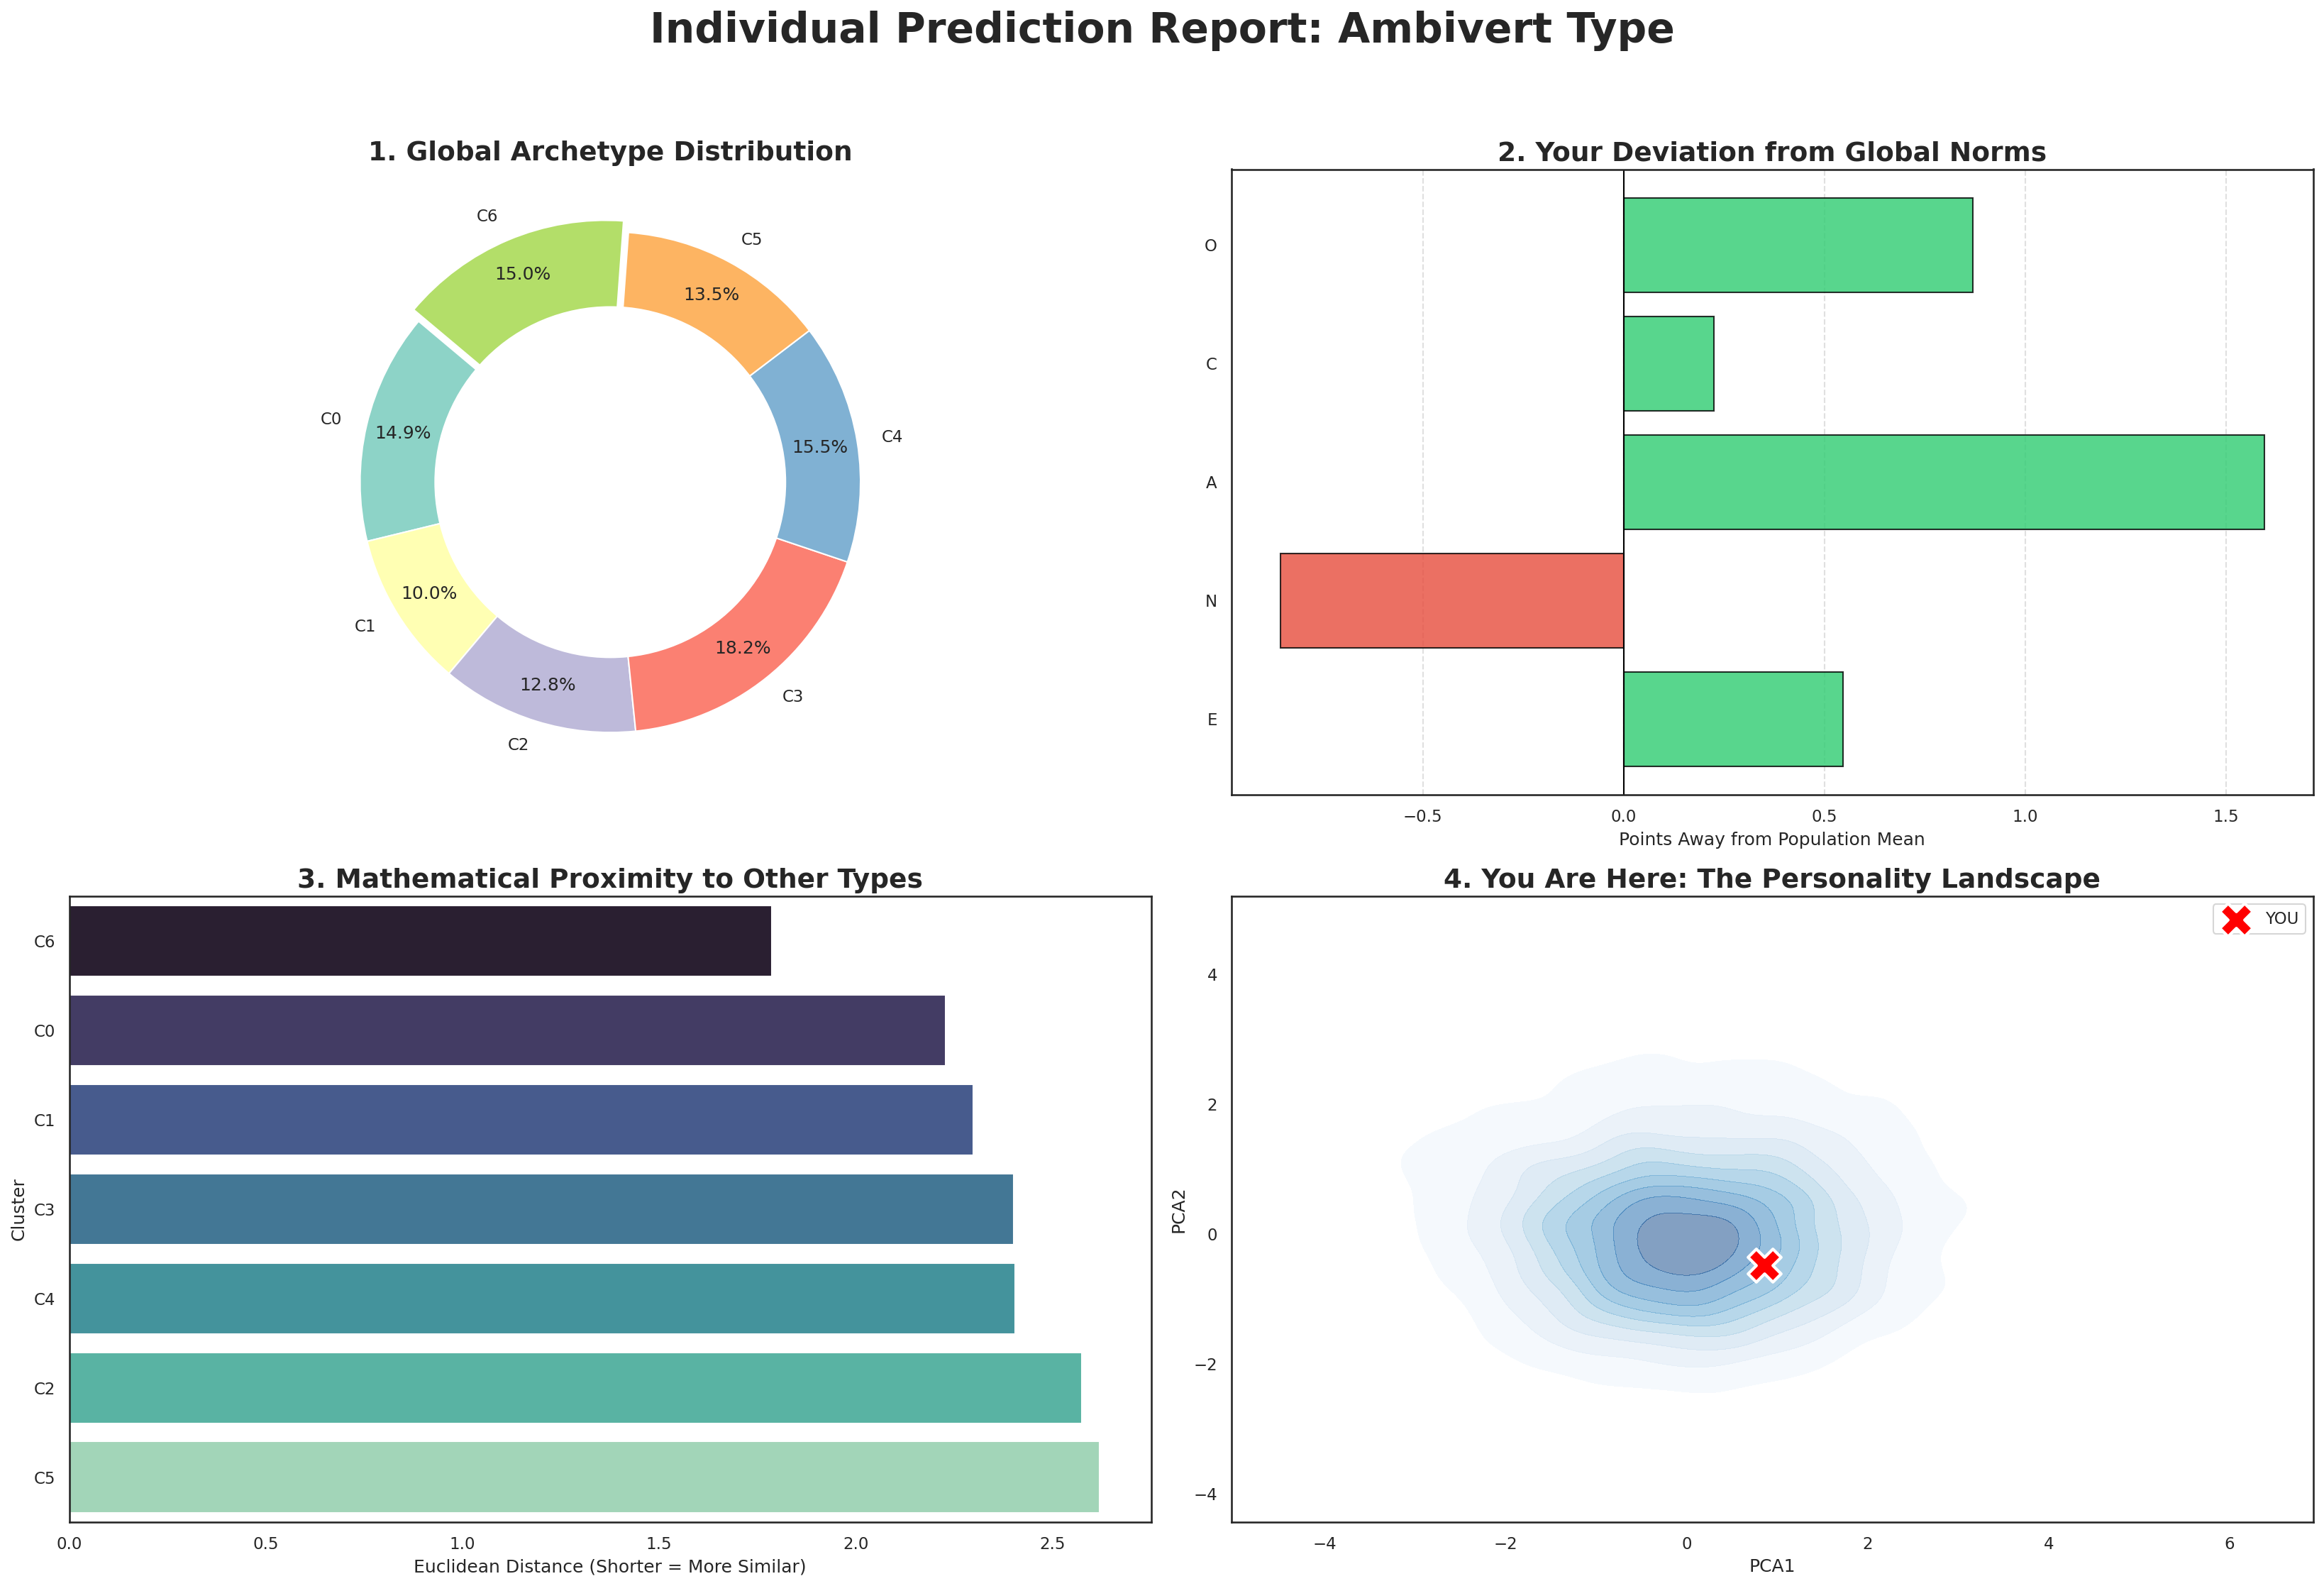

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare Prediction Data (Comparing the 'test_result' to the population)
user_traits = [test_result['E'], test_result['N'], test_result['A'], test_result['C'], test_result['O']]
global_means = df_big5[traits].mean().values
# Calculate Divergence (User - Average)
divergence = np.array(user_traits) - global_means

# 2. Calculate Distances to all Cluster Centers (Mathematical Proximity)
user_coords_5d = np.array(user_traits).reshape(1, -1)
# Distance = Square root of sum of squared differences
distances = np.sqrt(((cluster_centers.values - user_coords_5d)**2).sum(axis=1))
dist_df = pd.DataFrame({'Cluster': [f"C{i}" for i in range(7)], 'Distance': distances}).sort_values('Distance')

# Set high-definition style
plt.rcParams['figure.dpi'] = 150
sns.set_theme(style="white")

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
fig.suptitle(f"Individual Prediction Report: {test_result['archetype_label'].split(',')[0]} Type",
             fontsize=28, fontweight='bold', y=0.96)

# ------------------------------------------------------------------
# CHART 1: Population Proportions (Donut Chart)
# ------------------------------------------------------------------
# Replaces bar/lollipop. Shows the 'share' of each personality in the world.
counts = df_big5['Cluster'].value_counts().sort_index()
axes[0, 0].pie(counts, labels=[f"C{i}" for i in range(7)], autopct='%1.1f%%',
        startangle=140, colors=sns.color_palette("Set3"), pctdistance=0.85,
        explode=[0.05 if i == test_result['cluster'] else 0 for i in range(7)])
# Draw a white circle in the middle to make it a donut
center_circle = plt.Circle((0,0), 0.70, fc='white')
axes[0, 0].add_artist(center_circle)
axes[0, 0].set_title('1. Global Archetype Distribution', fontsize=18, fontweight='bold')

# ------------------------------------------------------------------
# CHART 2: The Personality Signature (Diverging Bar Chart)
# ------------------------------------------------------------------
# Shows if the user is 'Above' or 'Below' the world average for each trait
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in divergence]
axes[0, 1].barh(traits, divergence, color=colors, edgecolor='black', alpha=0.8)
axes[0, 1].axvline(0, color='black', linewidth=1)
axes[0, 1].set_title('2. Your Deviation from Global Norms', fontsize=18, fontweight='bold')
axes[0, 1].set_xlabel('Points Away from Population Mean')
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.6)

# ------------------------------------------------------------------
# CHART 3: Proximity Analysis (Distance to All Archetypes)
# ------------------------------------------------------------------
# Shows how "close" you are to other personality types. Shorter bar = More like that type.
sns.barplot(data=dist_df, x='Distance', y='Cluster', palette="mako", ax=axes[1, 0])
axes[1, 0].set_title('3. Mathematical Proximity to Other Types', fontsize=18, fontweight='bold')
axes[1, 0].set_xlabel('Euclidean Distance (Shorter = More Similar)')

# ------------------------------------------------------------------
# CHART 4: Topographic Pinpoint (Density Contour Map)
# ------------------------------------------------------------------
# Replaces Hexbin/Scatter. Shows the population landscape with a "You Are Here" marker.
df_sample_pca = df_big5.sample(10000)
sns.kdeplot(data=df_sample_pca, x='PCA1', y='PCA2', cmap="Blues", fill=True,
            thresh=0.05, levels=10, alpha=0.5, ax=axes[1, 1])
# Place the red X at the user's predicted coordinates
axes[1, 1].scatter(test_result['PCA1'], test_result['PCA2'], color='red',
                   marker='X', s=500, label='YOU', edgecolor='white', linewidth=2)
axes[1, 1].set_title('4. You Are Here: The Personality Landscape', fontsize=18, fontweight='bold')
axes[1, 1].legend(loc='upper right')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

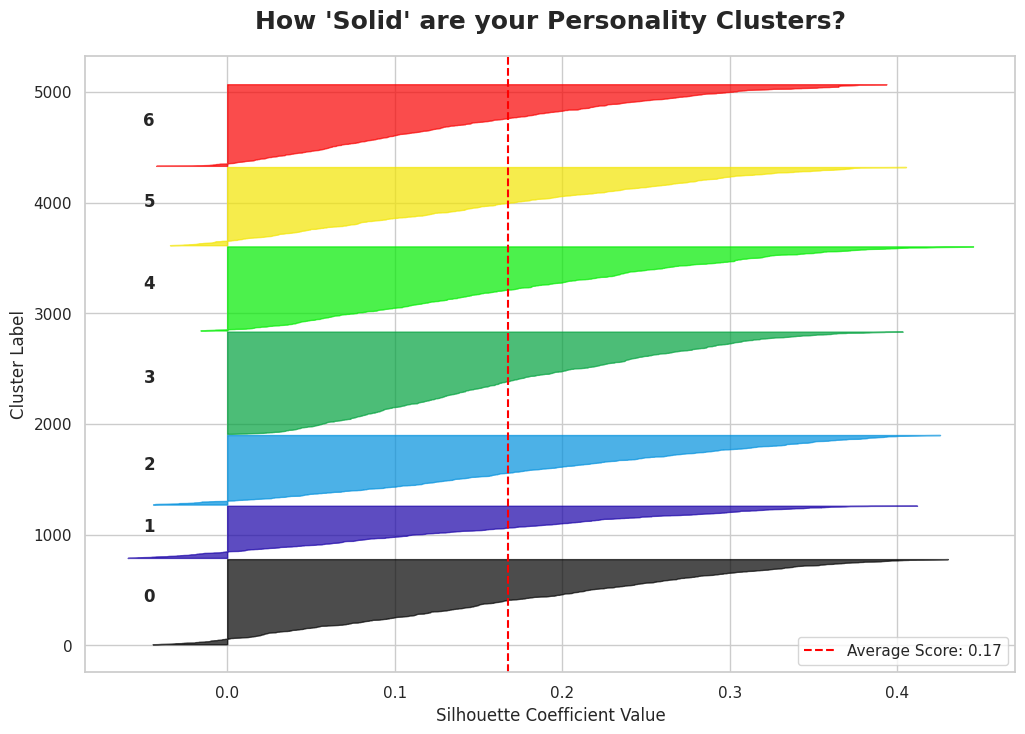

In [30]:
import matplotlib.cm as cm

# 7. Silhouette Plot: Measuring Clustering Quality
# Note: Silhouette is very heavy. We take a 5,000-point sample for speed.
sample_size = 5000
df_sil = df_big5.sample(sample_size, random_state=42)
X_sil = df_sil[["E", "N", "A", "C", "O"]].values
cluster_labels_sil = df_sil["Cluster"].values

from sklearn.metrics import silhouette_samples, silhouette_score

# Calculate silhouette scores for each point
sample_silhouette_values = silhouette_samples(X_sil, cluster_labels_sil)
avg_score = silhouette_score(X_sil, cluster_labels_sil)

fig, ax = plt.subplots(figsize=(12, 8))
y_lower = 10

for i in range(best_k):
    # Aggregate scores for points in this cluster and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_sil == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontweight='bold')
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.axvline(x=avg_score, color="red", linestyle="--", label=f'Average Score: {avg_score:.2f}')
ax.set_title("How 'Solid' are your Personality Clusters?", fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel("Silhouette Coefficient Value", fontsize=12)
ax.set_ylabel("Cluster Label", fontsize=12)
ax.legend()
plt.show()

/tmp/ipython-input-3240069399.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_melted, x='Cluster', y='Score', palette="viridis", ax=axes[1, 0])


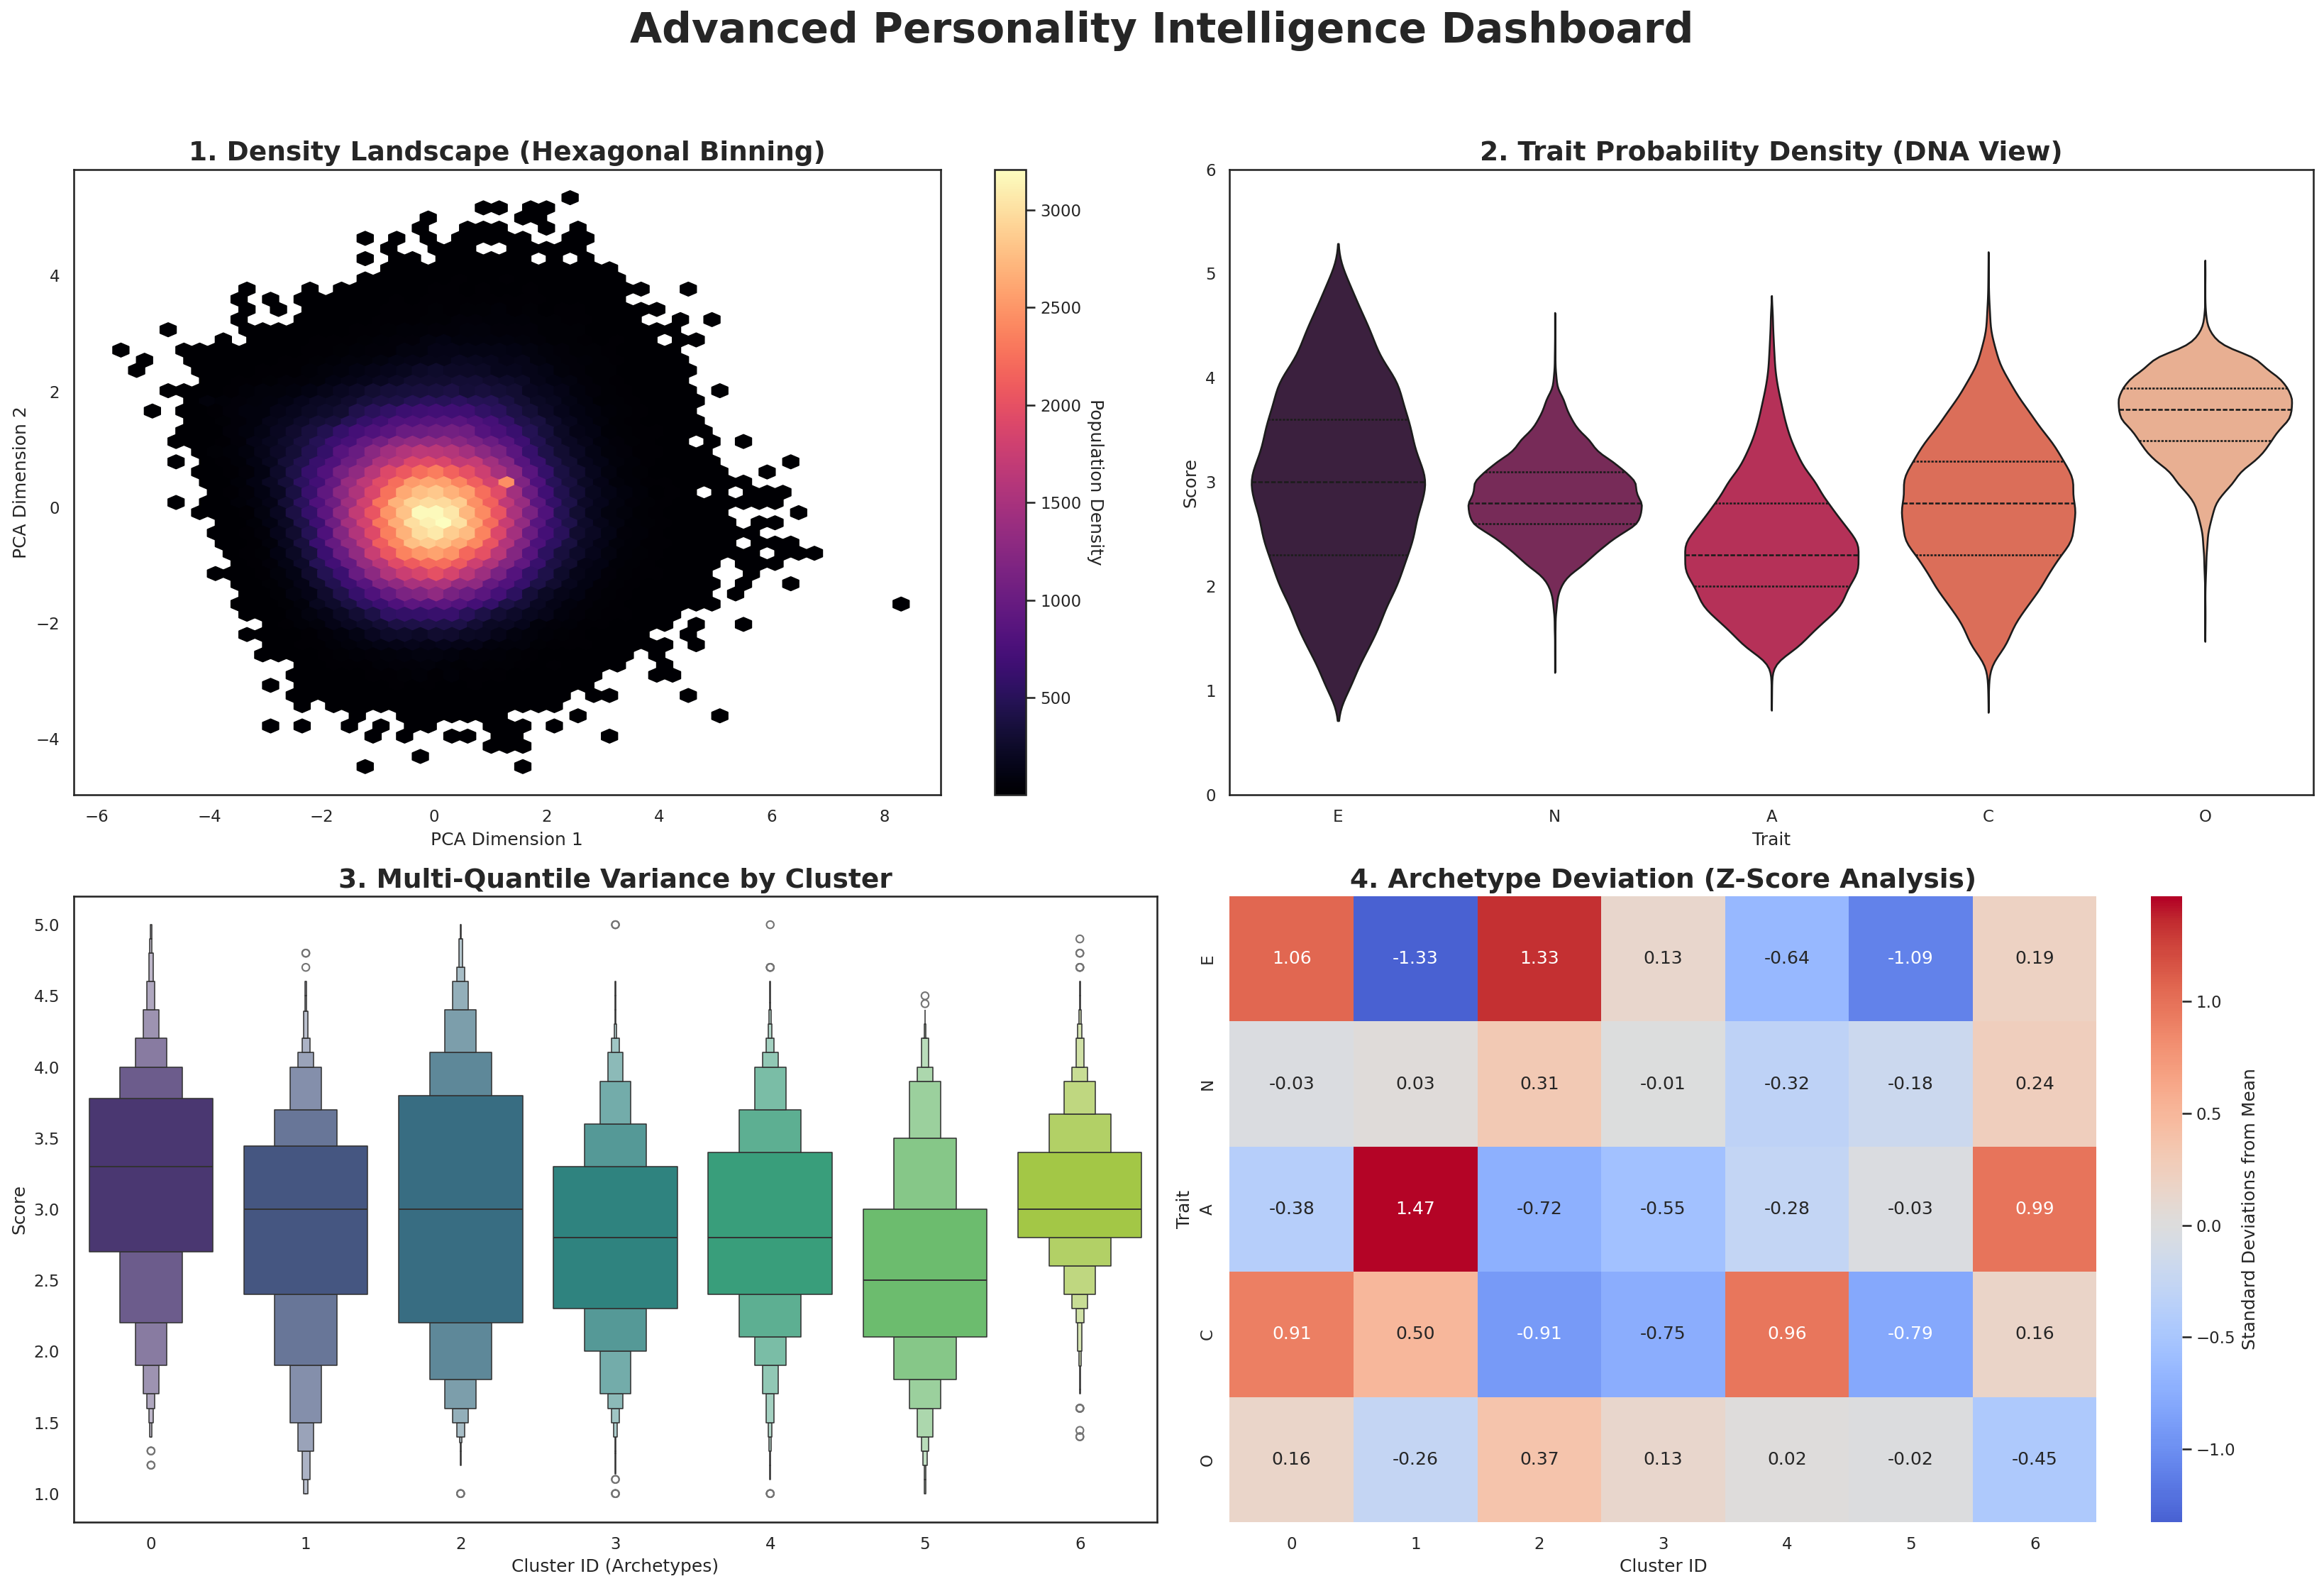

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare Data: Calculate Z-Scores (Relative Deviation)
# This shows how many Standard Deviations a cluster is away from the global average
traits = ["E", "N", "A", "C", "O"]
global_mean = df_big5[traits].mean()
global_std = df_big5[traits].std()
cluster_z_scores = (cluster_centers - global_mean) / global_std

# 2. Melt data for complex distribution plots
df_melted = df_big5.sample(10000).melt(id_vars=['Cluster'], value_vars=traits,
                                       var_name='Trait', value_name='Score')

# Set aesthetic style
plt.rcParams['figure.dpi'] = 150
sns.set_theme(style="white", palette="muted")

fig, axes = plt.subplots(2, 2, figsize=(22, 16))
fig.suptitle('Advanced Personality Intelligence Dashboard', fontsize=28, fontweight='bold', y=0.96)

# ---------------------------------------------------------
# CHART 1: Hexbin Density Map (The "Personality Nebula")
# ---------------------------------------------------------
# This uses a honeycomb grid to show where the 700k people are most concentrated
hb = axes[0, 0].hexbin(df_big5['PCA1'], df_big5['PCA2'], gridsize=50, cmap='magma', mincnt=1)
axes[0, 0].set_title('1. Density Landscape (Hexagonal Binning)', fontsize=18, fontweight='bold')
axes[0, 0].set_xlabel('PCA Dimension 1', fontsize=12)
axes[0, 0].set_ylabel('PCA Dimension 2', fontsize=12)
cb = fig.colorbar(hb, ax=axes[0, 0])
cb.set_label('Population Density', rotation=270, labelpad=15)

# ---------------------------------------------------------
# CHART 2: Violin "DNA" Profiles
# ---------------------------------------------------------
# Shows the probability density—wider parts mean more people have that score
sns.violinplot(data=df_melted, x='Trait', y='Score', hue='Trait',
               inner="quart", palette="rocket", ax=axes[0, 1], legend=False)
axes[0, 1].set_title('2. Trait Probability Density (DNA View)', fontsize=18, fontweight='bold')
axes[0, 1].set_ylim(0, 6)

# ---------------------------------------------------------
# CHART 3: Boxen Plots (Large-Scale Distribution)
# ---------------------------------------------------------
# Shows many more quantiles than a standard boxplot—perfect for 700k rows
sns.boxenplot(data=df_melted, x='Cluster', y='Score', palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title('3. Multi-Quantile Variance by Cluster', fontsize=18, fontweight='bold')
axes[1, 0].set_xlabel('Cluster ID (Archetypes)')

# ---------------------------------------------------------
# CHART 4: Z-Score Deviation Matrix (The "Insight" Map)
# ---------------------------------------------------------
# Red = Highly Above Average, Blue = Highly Below Average
sns.heatmap(cluster_z_scores.T, annot=True, fmt=".2f", cmap="coolwarm",
            center=0, ax=axes[1, 1], cbar_kws={'label': 'Standard Deviations from Mean'})
axes[1, 1].set_title('4. Archetype Deviation (Z-Score Analysis)', fontsize=18, fontweight='bold')
axes[1, 1].set_ylabel('Trait')
axes[1, 1].set_xlabel('Cluster ID')

# Final Polish
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [28]:
import json

# Compute 33% and 67% quantiles for each trait
q = df_big5[["E", "N", "A", "C", "O"]].quantile([0.33, 0.67])

quantiles_dict = {}
for trait in ["E", "N", "A", "C", "O"]:
    quantiles_dict[trait] = {
        "low": float(q.loc[0.33, trait]),
        "high": float(q.loc[0.67, trait])
    }

print("Quantiles dictionary:")
print(quantiles_dict)

# Save to JSON file
with open("quantiles.json", "w") as f:
    json.dump(quantiles_dict, f, indent=4)

print("Saved quantiles.json")


Quantiles dictionary:
{'E': {'low': 2.5, 'high': 3.4}, 'N': {'low': 2.7, 'high': 3.0}, 'A': {'low': 2.1, 'high': 2.6}, 'C': {'low': 2.5, 'high': 3.1}, 'O': {'low': 3.5, 'high': 3.8}}
Saved quantiles.json
